# 0.0. Imports

In [1]:
import pandas as pd
import numpy  as np

import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
from matplotlib import gridspec

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model    as lm


from IPython.core.display  import HTML
from IPython.display       import Image

from scipy      import stats           as ss
from sklearn.ensemble        import RandomForestRegressor
from boruta                  import BorutaPy
import pickle

import xgboost                 as xgb
from lightgbm                  import LGBMClassifier
from sklearn.naive_bayes       import GaussianNB
import random
from catboost import CatBoostClassifier
from sklearn.svm import SVC

## 0.1 Helper Function

In [2]:
#ajusta graficos
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 40
    
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

#Retirar notação cientifica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#cramer V Function
def cramer_v( x, y ):
    cm = np.asmatrix ( pd.crosstab( x, y ) )
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr / n ) / min( kcorr-1, rcorr-1 ) )


def percentage_pandas(df1, df_total ):
    percentage = df1.shape[0]/df_total.shape[0] *100
    return percentage

# precision_at_k
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']


def model_results (model_ml, model_name, x_val,y_val, k ):
    
    precision_list = []
    recall_list = []
    f1score_list = []
    
    #prediction
    yhat_proba_model = model_ml.predict_proba(x_val)

    # copy dataframe
    df = x_val.copy()
    
    df['response'] = y_val.copy()
    

    # propensity score --> [:, 1] classe 1
    df['score'] = yhat_proba_model[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_model = precision_at_k( df, k )
    
    
    # compute recall at k
    recall_model = recall_at_k( df, k )
    
    # salvando
    precision_list.append(precision_model)
    recall_list.append(recall_model)

    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})
    
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_model,
               'Recall_at_k': recall_model}
            
    #model_rank = model_rank.append(new_row, ignore_index = True)
    aux1 = pd.DataFrame([new_row])
    model_rank = pd.concat([model_rank,aux1], ignore_index = True, axis=0)
    
    print('\n',model_rank,'\n')
    
    # plot cumulative_gain  
    skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_model, title='Cumulative Gain Curve');
    
    # plot lift curve
    skplt.metrics.plot_lift_curve(y_val, yhat_proba_model,title='Lift Curve');
    
    return model_rank



def cross_validation( num_folds, model_name, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train, y_train):
        
        # training and validation datasets
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        # modeling
        model_fit = model.fit(x_train_fold,y_train_fold.values.ravel())
        
        # predict
        yhat_model = model_fit.predict_proba(x_val_fold)
        
        # performance
        df = x_val_fold.copy() # copia do dataset de validação
        df['response'] = y_val_fold.copy() # acrescentar a coluna response no dataset
        df['score'] = yhat_model[:, 1].tolist() #acrescentar a coluna score
        df = df.sort_values('score',ascending=False) 
        
        #Metrics Precision @k
        precision = round( precision_at_k(df,k), 3 )
        precision_list.append(precision)
        
        #Metrics Recall @k
        recall = round( recall_at_k(df,k), 3 )
        recall_list.append(recall)     
        
        #results mean
        precision_mean, precision_std = (round(np.mean(precision_list), 4),round(np.std(precision_list),4))
        recall_mean, recall_std       = (round(np.mean(recall_list), 4),round(np.std(recall_list),4))
        
                
        i+=1
    
    precision_str = precision_mean.astype(str) + ' +/- ' + precision_std.astype(str)
    recall_str    = recall_mean.astype(str)    + ' +/- ' + recall_std.astype(str)
    
    # dataframe
    model_rank = pd.DataFrame(columns = {'Model':[], "Precision_at_k": [], "Recall_at_k": []})   
    new_row = {'Model': model_name, 
               'Precision_at_k': precision_str,
               'Recall_at_k': recall_str }
    
    aux1 = pd.DataFrame([new_row])
    models_performance = pd.concat([model_rank,aux1], ignore_index = True, axis=0)

    return models_performance

In [3]:
jupyter_settings()

# 7.0. Machine Learning

## Loading

In [4]:
df5 = pd.read_csv( './pickle/version_2/df5.csv' )
y_train = pd.read_csv( './pickle/version_2/y_train.csv' )
x_validation = pd.read_csv( './pickle/version_2/x_validation.csv' )
y_validation= pd.read_csv( './pickle/version_2/y_validation.csv' )

In [5]:
df5          = df5.drop(['Unnamed: 0'], axis = 1 )
y_train      = y_train.drop(['Unnamed: 0'], axis = 1 )
x_validation = x_validation.drop(['Unnamed: 0'], axis = 1 )
y_validation = y_validation.drop(['Unnamed: 0'], axis = 1 )


In [6]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation

model_rank = pd.DataFrame(columns={'Model':[], "Precision_at_k": [], "Recall_at_k": []})

### Check Na

In [7]:
x_train.isna().sum()

annual_premium          0
vintage                 0
age                     0
region_code             0
vehicle_damage          0
previously_insured      0
policy_sales_channel    0
dtype: int64

In [8]:
y_train.isna().sum()

response    0
dtype: int64

In [9]:
x_val.isna().sum()

annual_premium          0
vintage                 0
age                     0
region_code             0
vehicle_damage          0
previously_insured      0
policy_sales_channel    0
dtype: int64

In [10]:
y_val.isna().sum()

response    0
dtype: int64

## 7.1. KNN


             Model  Precision_at_k  Recall_at_k
0  KNN Classifier            0.29         0.63 



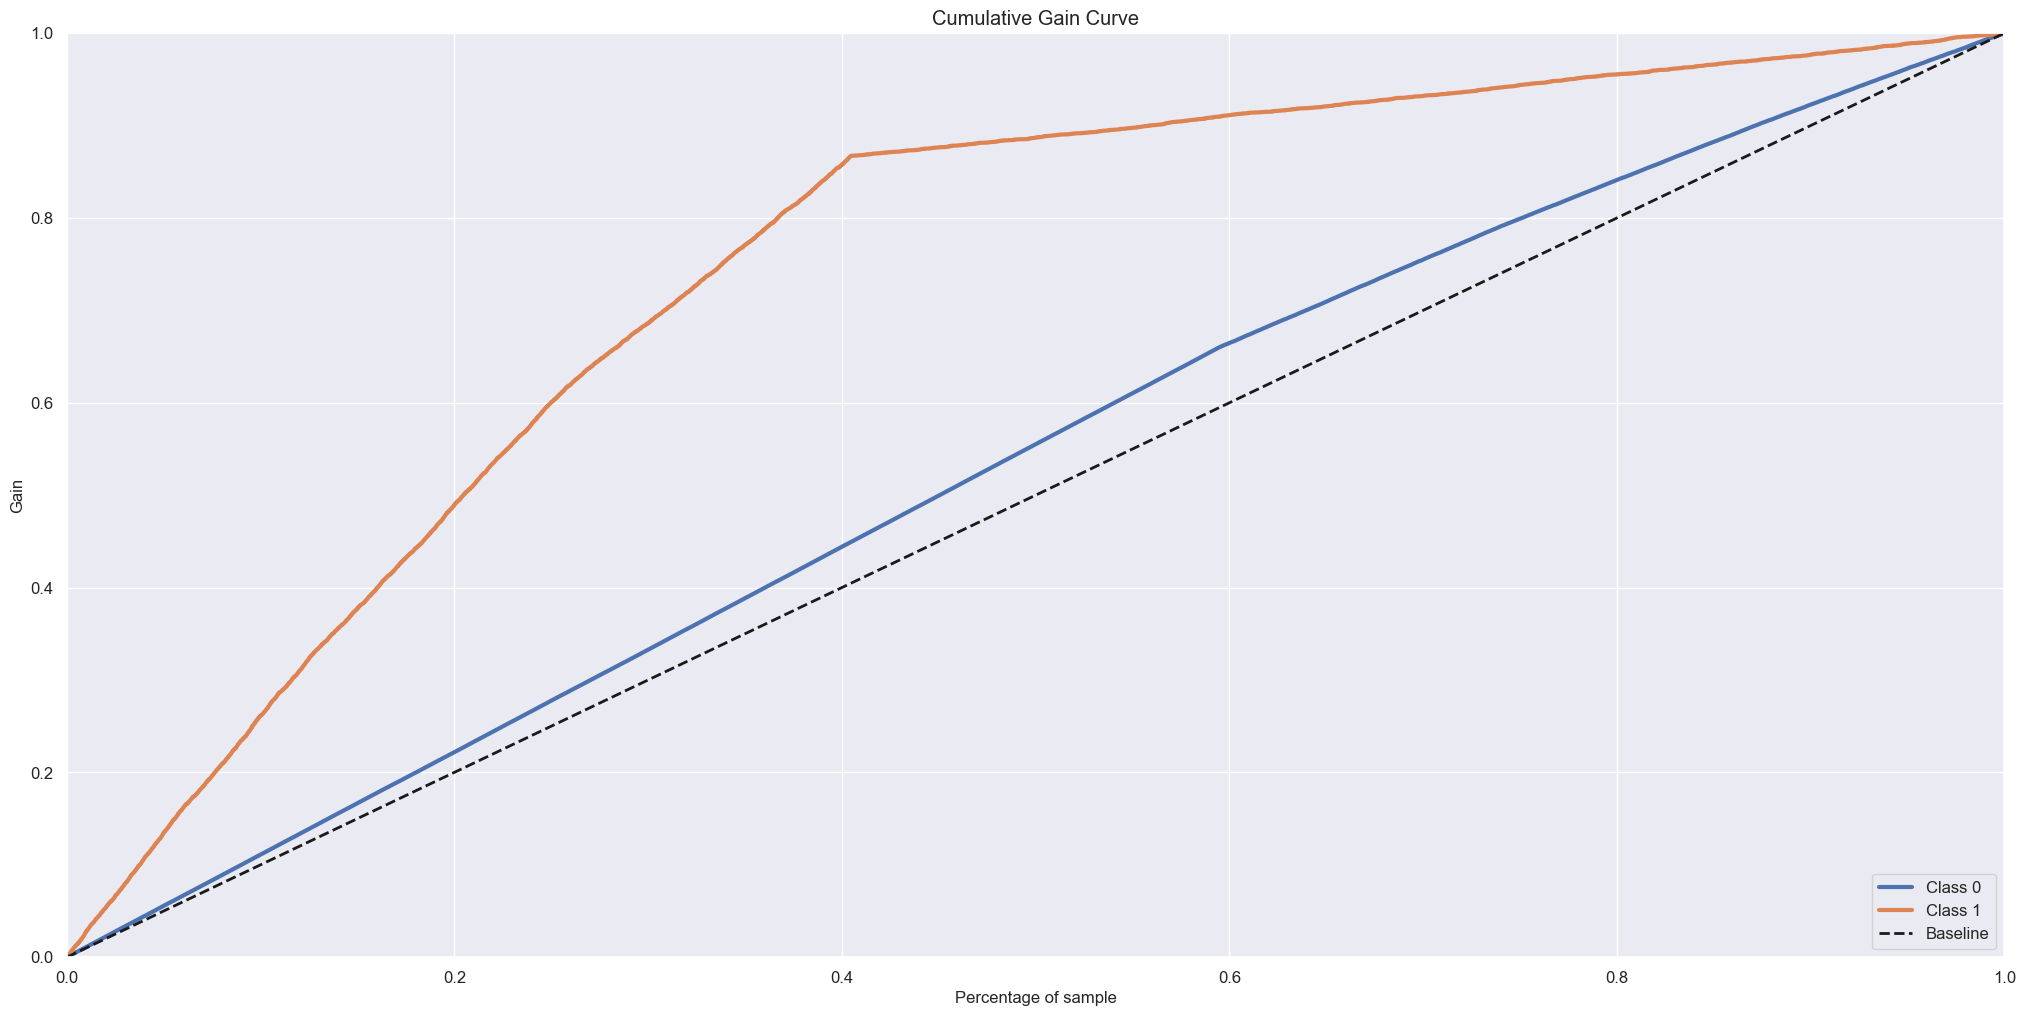

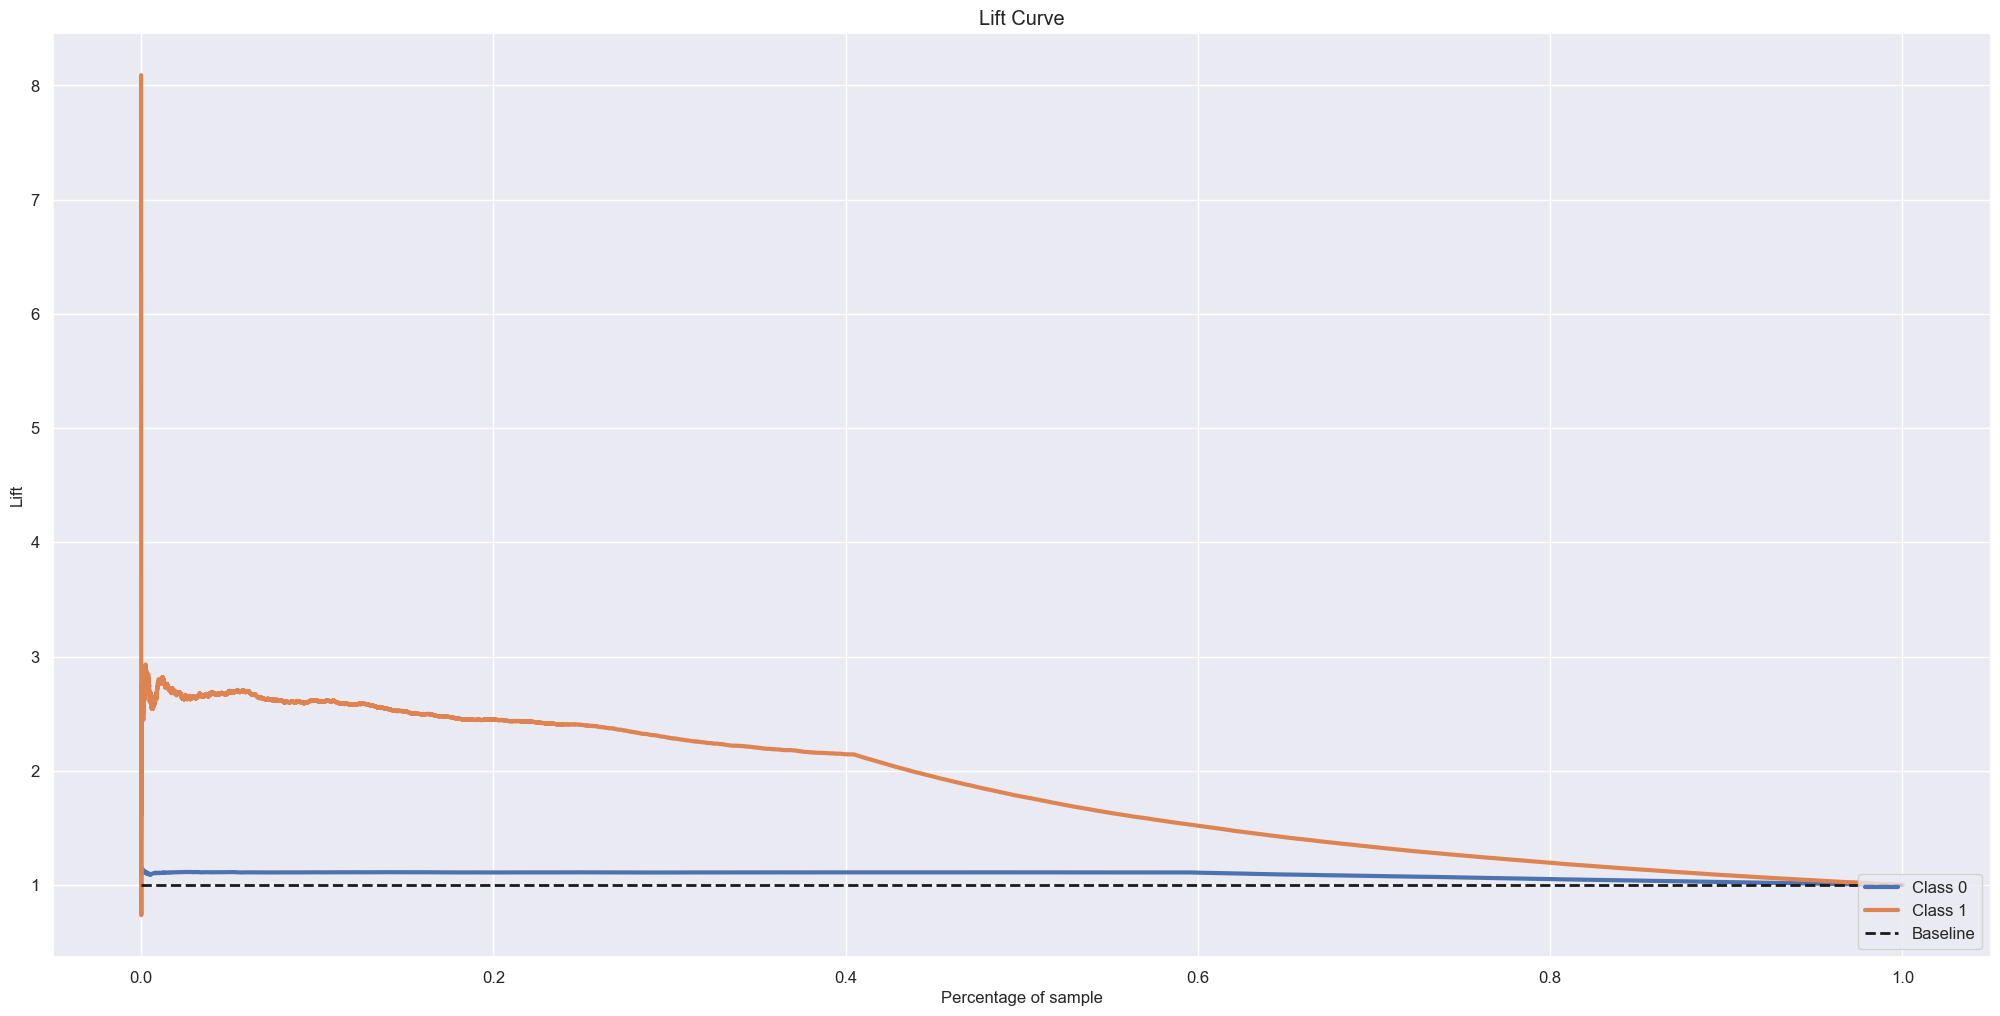

In [11]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train.values.ravel() )
pickle.dump(knn_model, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/knn_model.pkl','wb') )

# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_val )

model_rank_1 = model_results (knn_model, "KNN Classifier",  x_val, y_val, 20000 )

In [12]:
model_rank_1

,Model,Precision_at_k,Recall_at_k
0,KNN Classifier,0.29,0.63


## 7.2 Regressão Logística


                             Model  Precision_at_k  Recall_at_k
0  Logistic Regression Classifier            0.29         0.62 



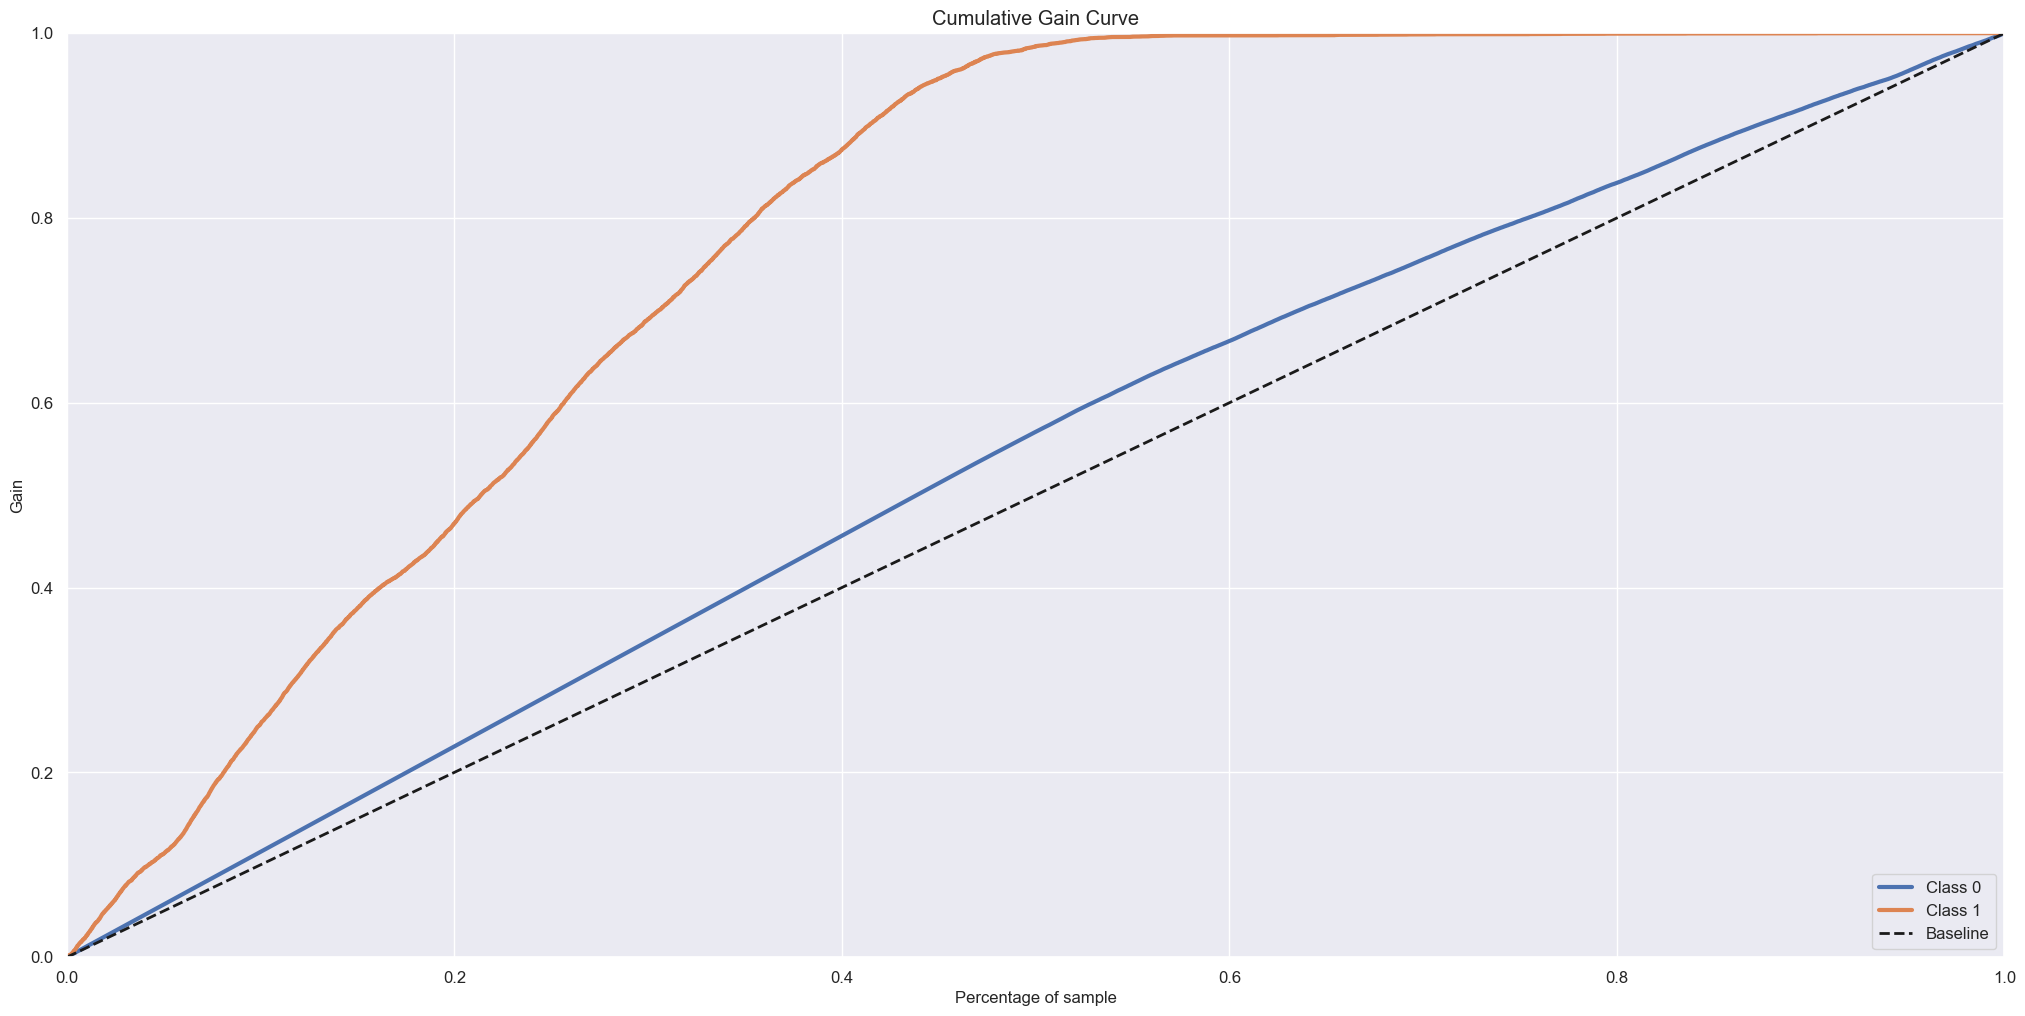

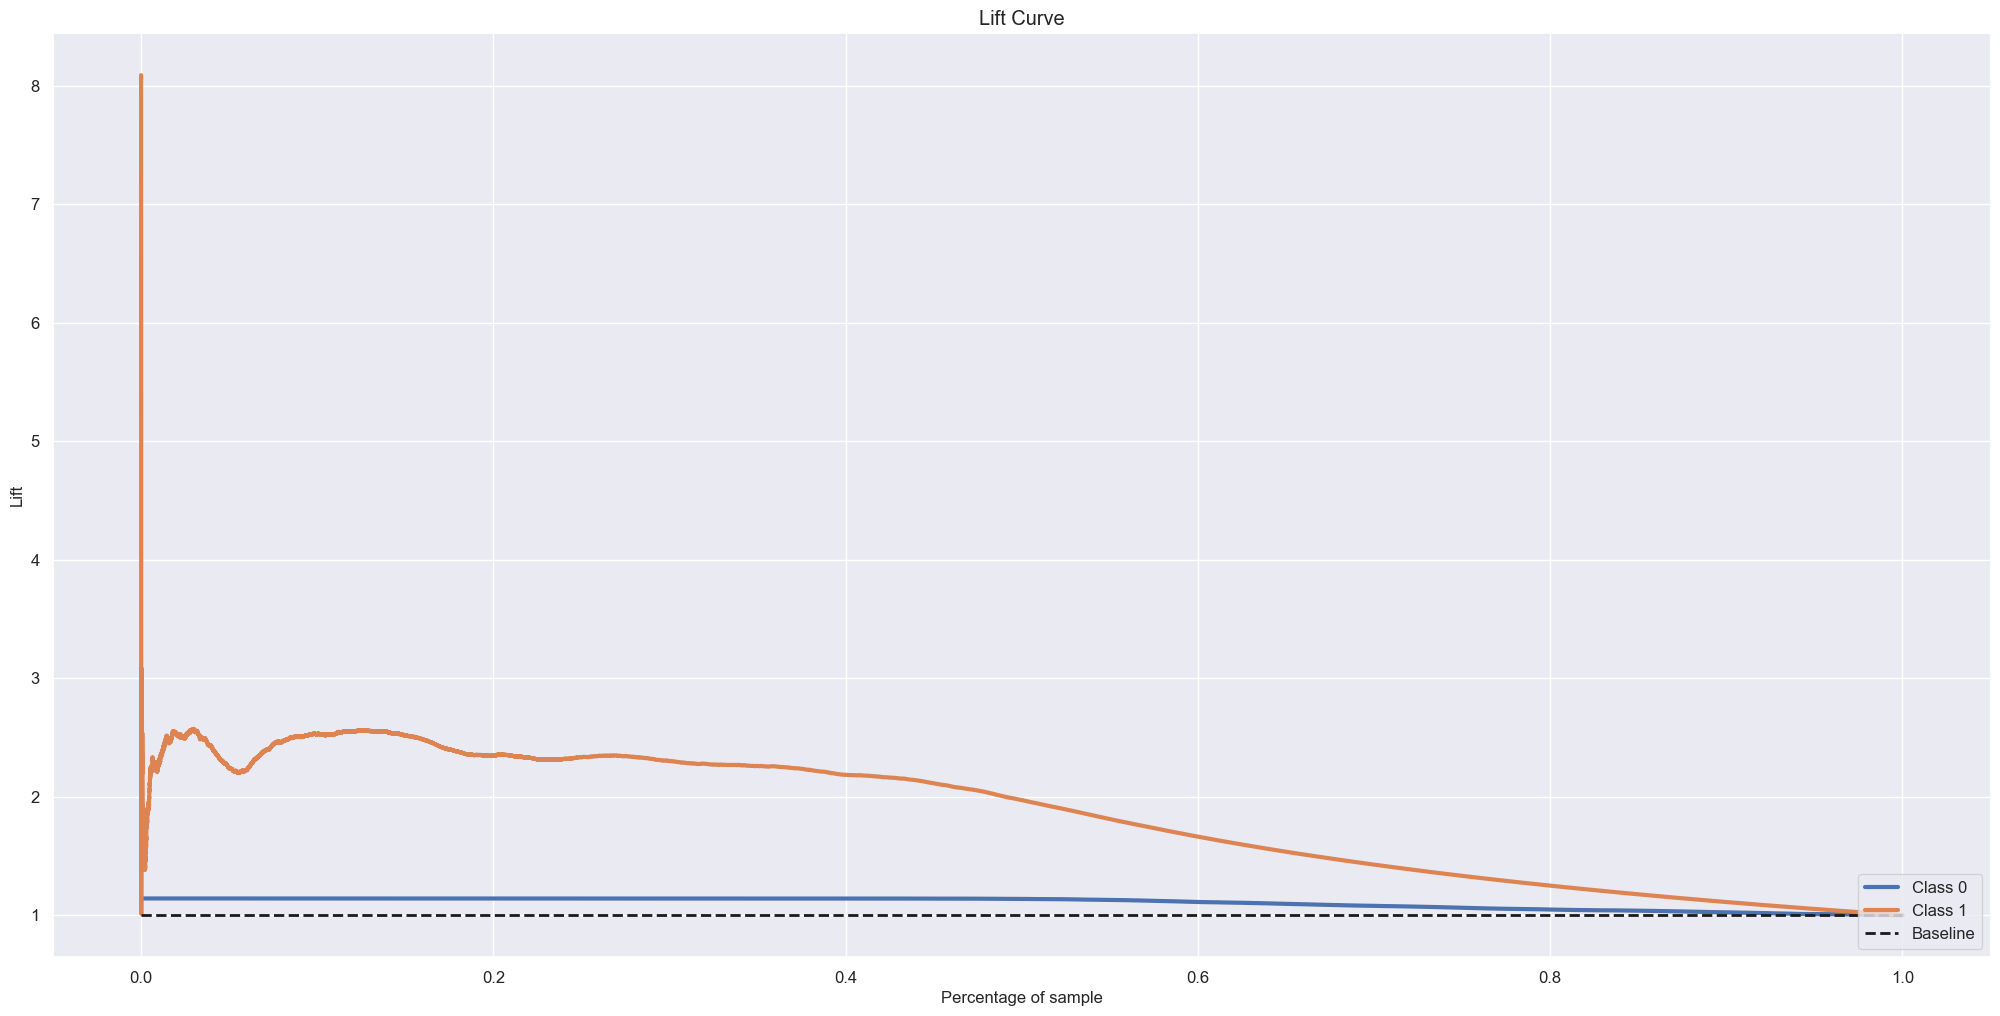

In [13]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train.values.ravel() )
pickle.dump(lr_model, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/lr_model.pkl','wb') )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

model_rank_2 = model_results (lr_model, "Logistic Regression Classifier", x_val, y_val, 20000 )

## 7.3. Extra Trees


                     Model  Precision_at_k  Recall_at_k
0  Extra Trees Classifier            0.30         0.65 



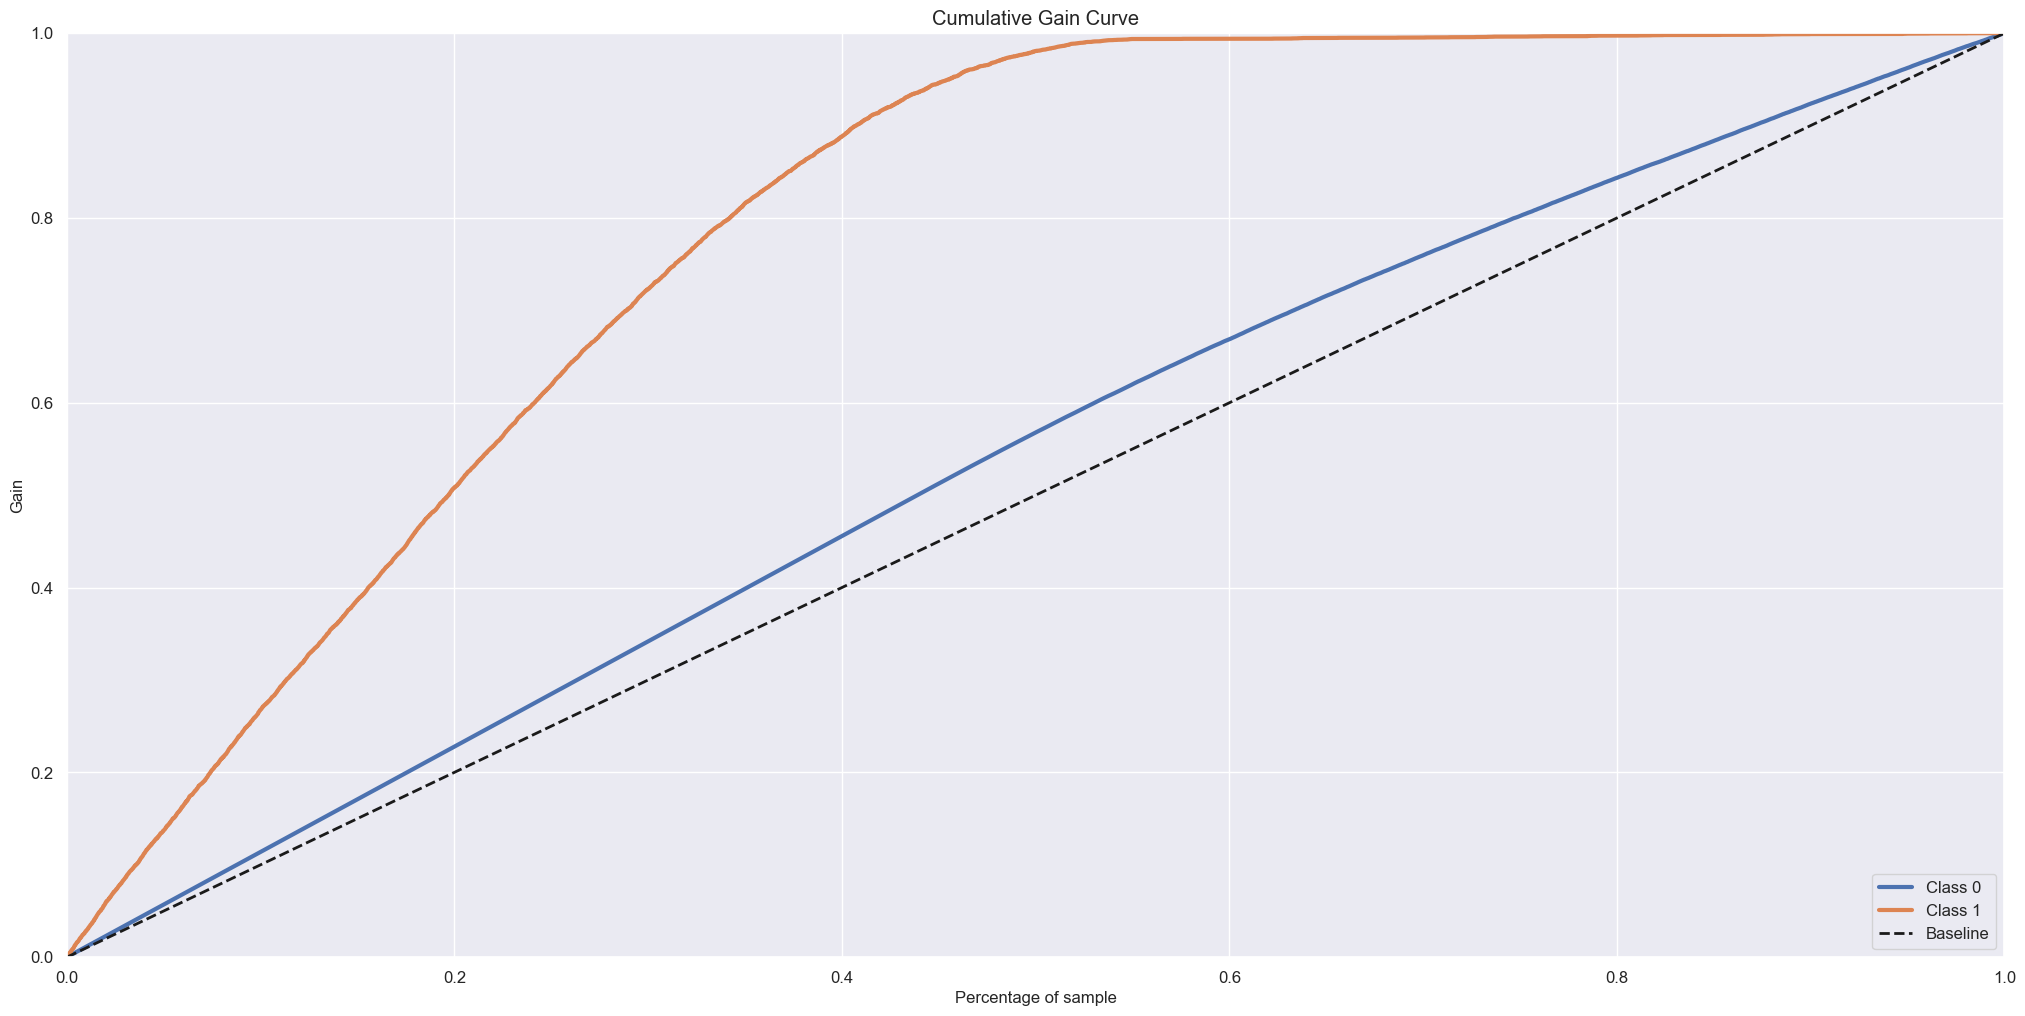

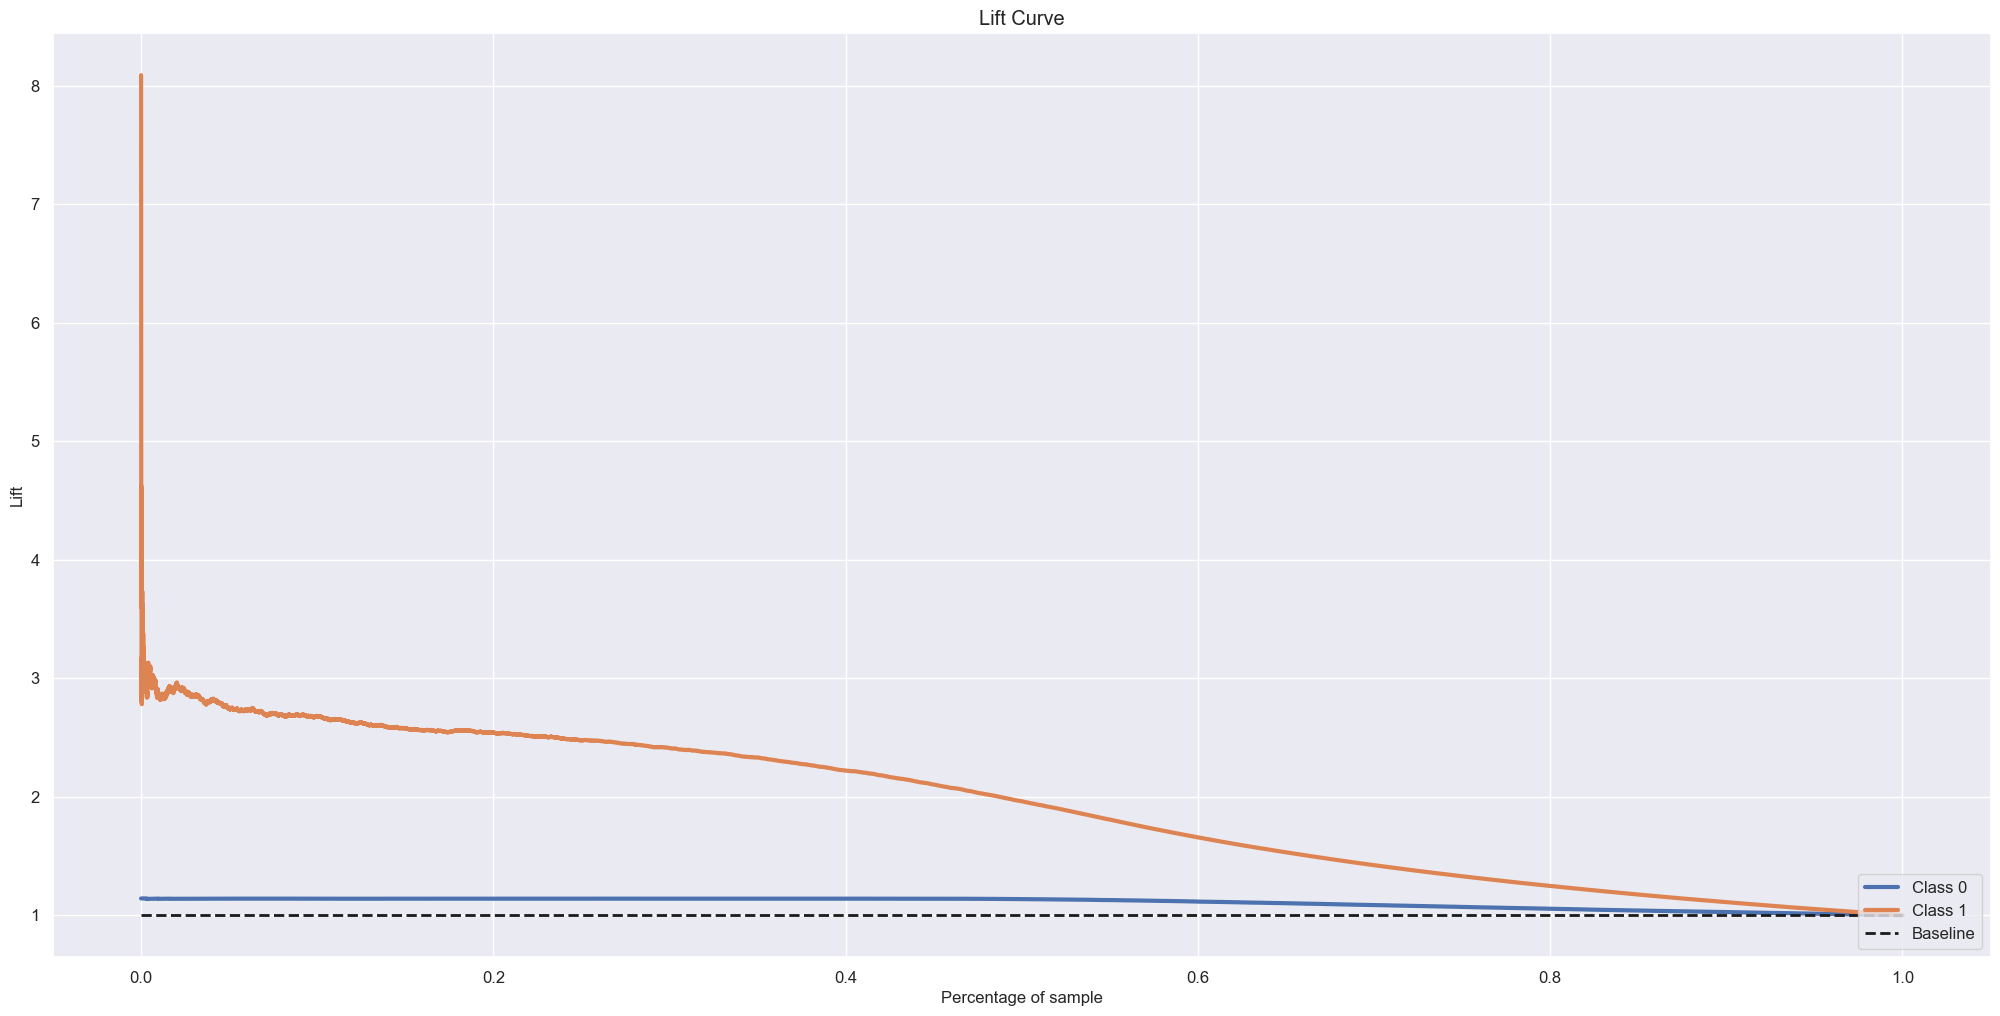

In [14]:
# model definition n_estimators=200 

et = en.ExtraTreesClassifier( n_estimators=200, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train, y_train.values.ravel() )
pickle.dump(et, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/et.pkl','wb') )

# model predict
yhat_et = et.predict_proba( x_val )

model_rank_3 = model_results (et, "Extra Trees Classifier", x_val, y_val, 20000 )

In [15]:
model_rank_3

,Model,Precision_at_k,Recall_at_k
0,Extra Trees Classifier,0.30,0.65


## 7.4 Random Forest


                       Model  Precision_at_k  Recall_at_k
0  Random Forest Classifier            0.31         0.66 



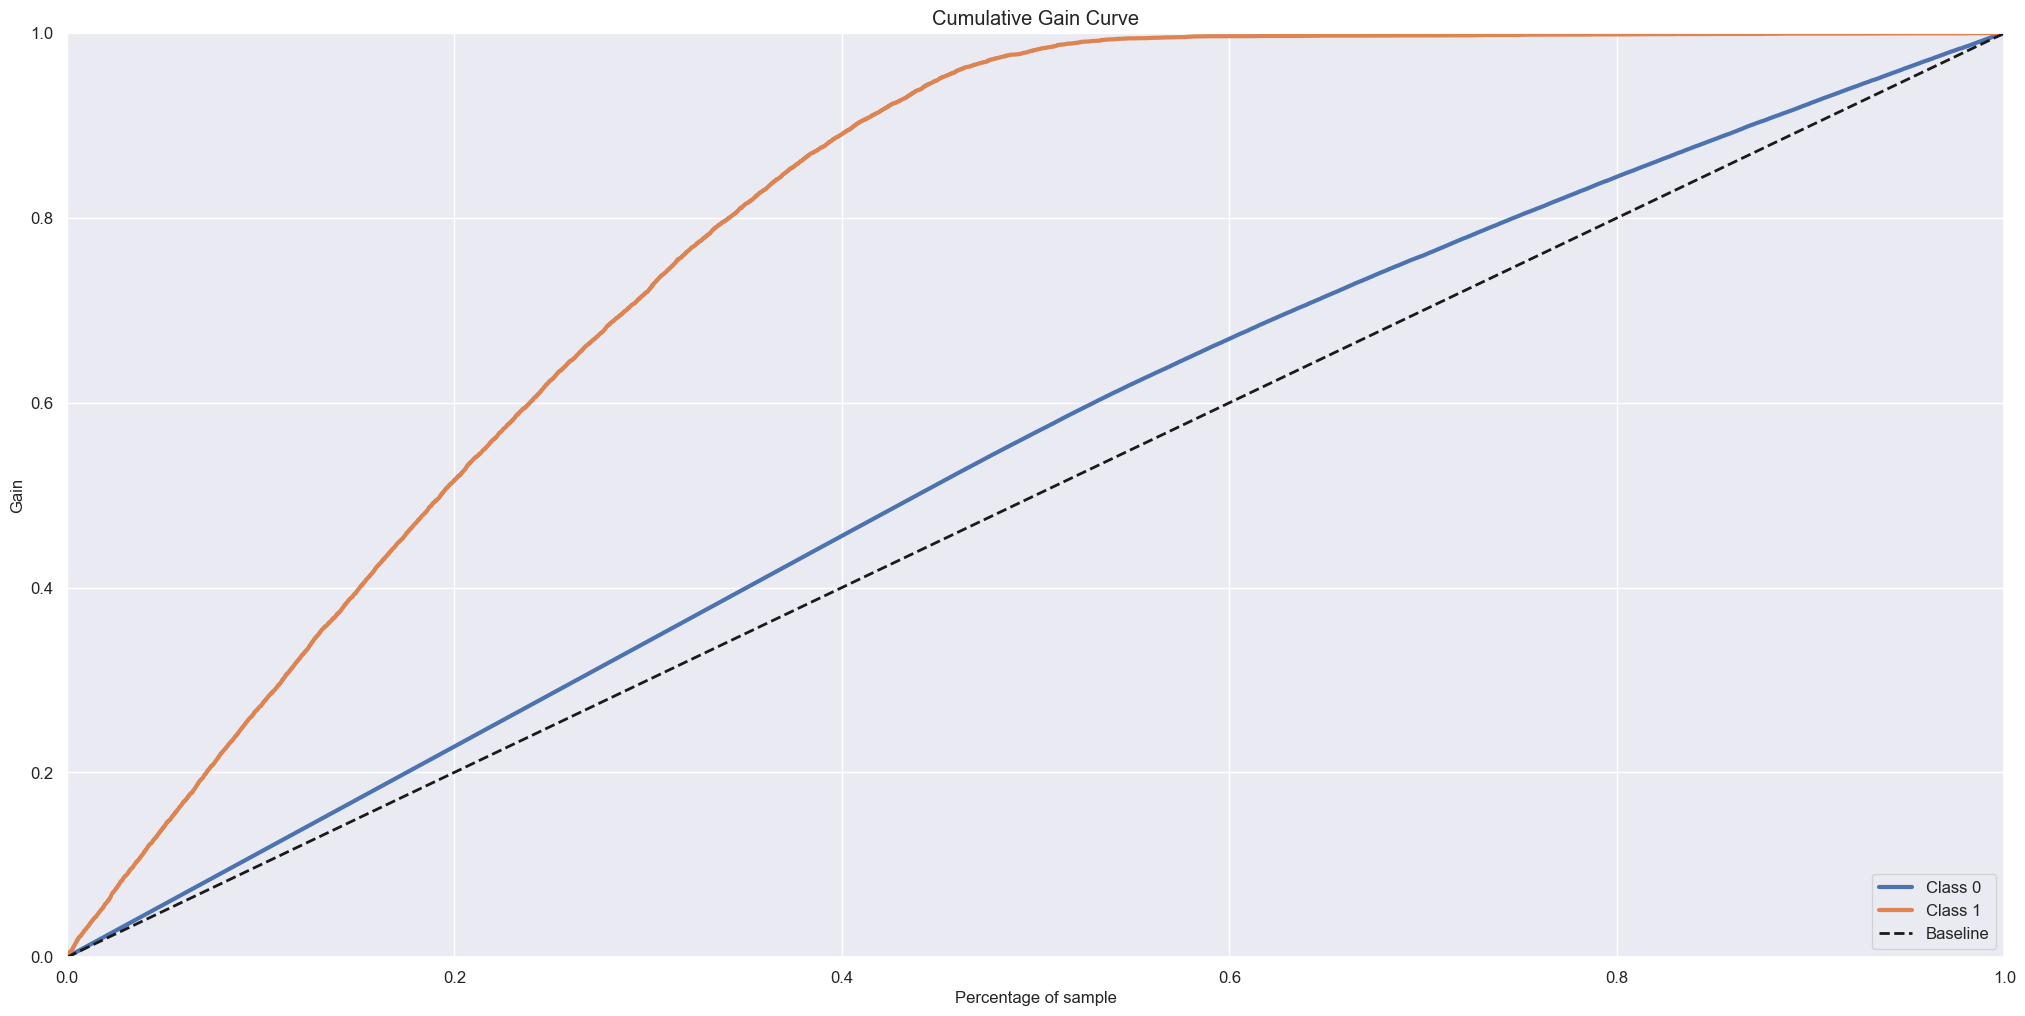

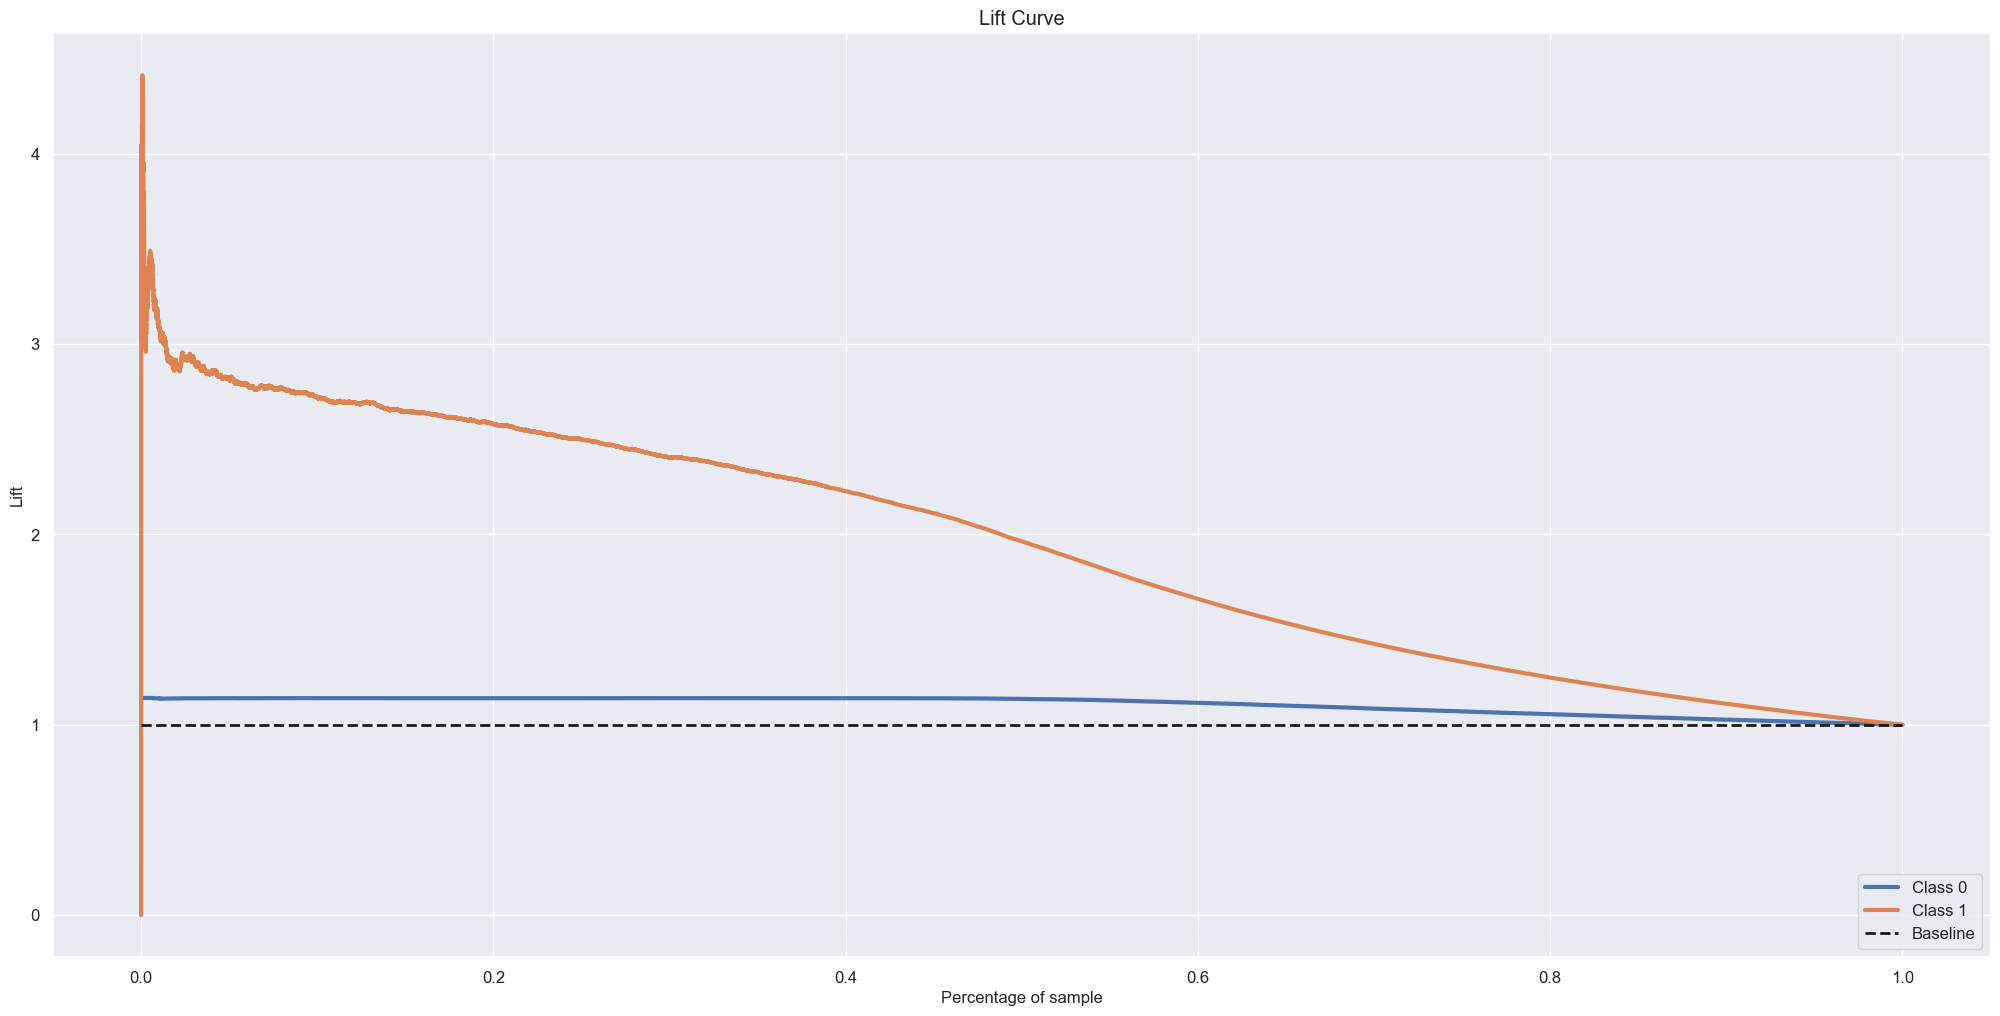

In [16]:
# model definition
rf = en.RandomForestClassifier( n_estimators=550, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train.values.ravel())
pickle.dump(rf, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/rf.pkl','wb') )

# model prediction
yhat_rf = rf.predict_proba( x_val )

model_rank_4 = model_results (rf, "Random Forest Classifier", x_val, y_val, 20000 )

In [17]:
model_rank_4

,Model,Precision_at_k,Recall_at_k
0,Random Forest Classifier,0.31,0.66


## 7.5 XGBoost


                 Model  Precision_at_k  Recall_at_k
0  XGBoost Classifier            0.33         0.71 



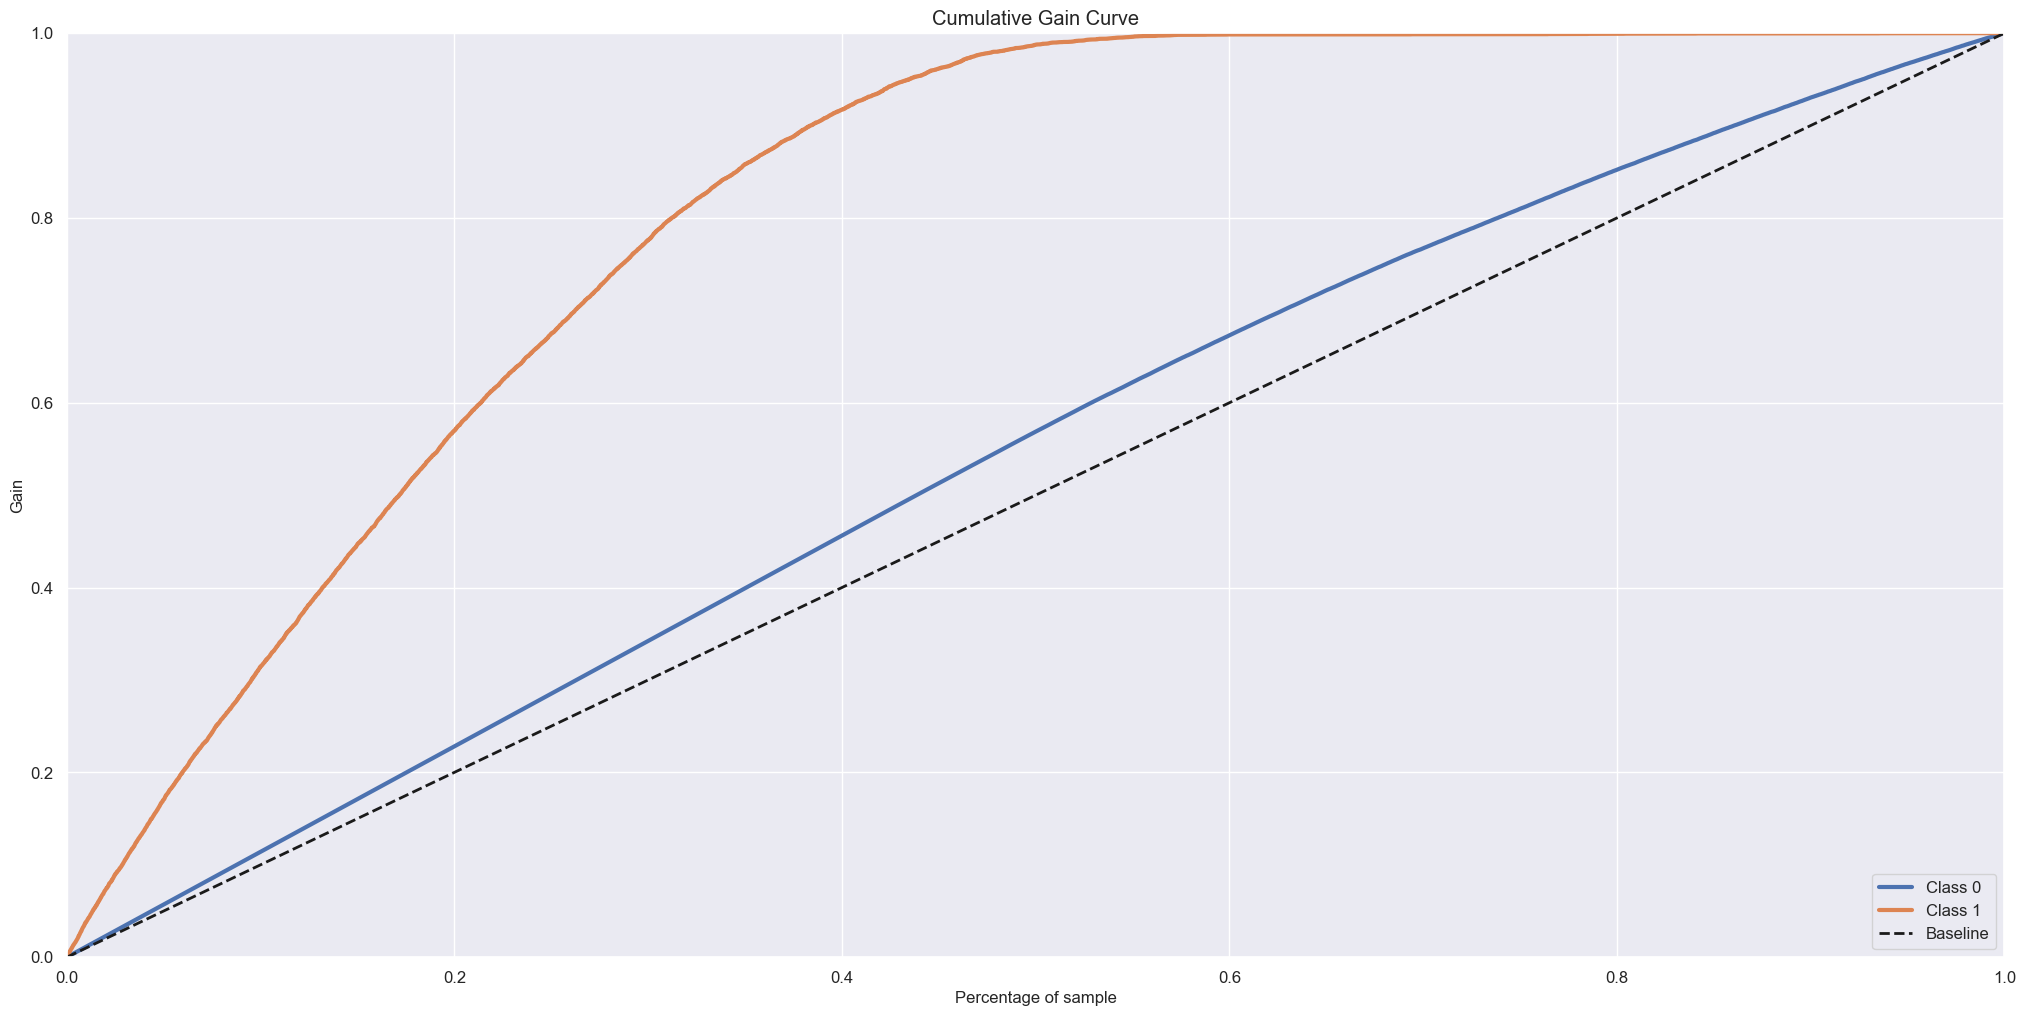

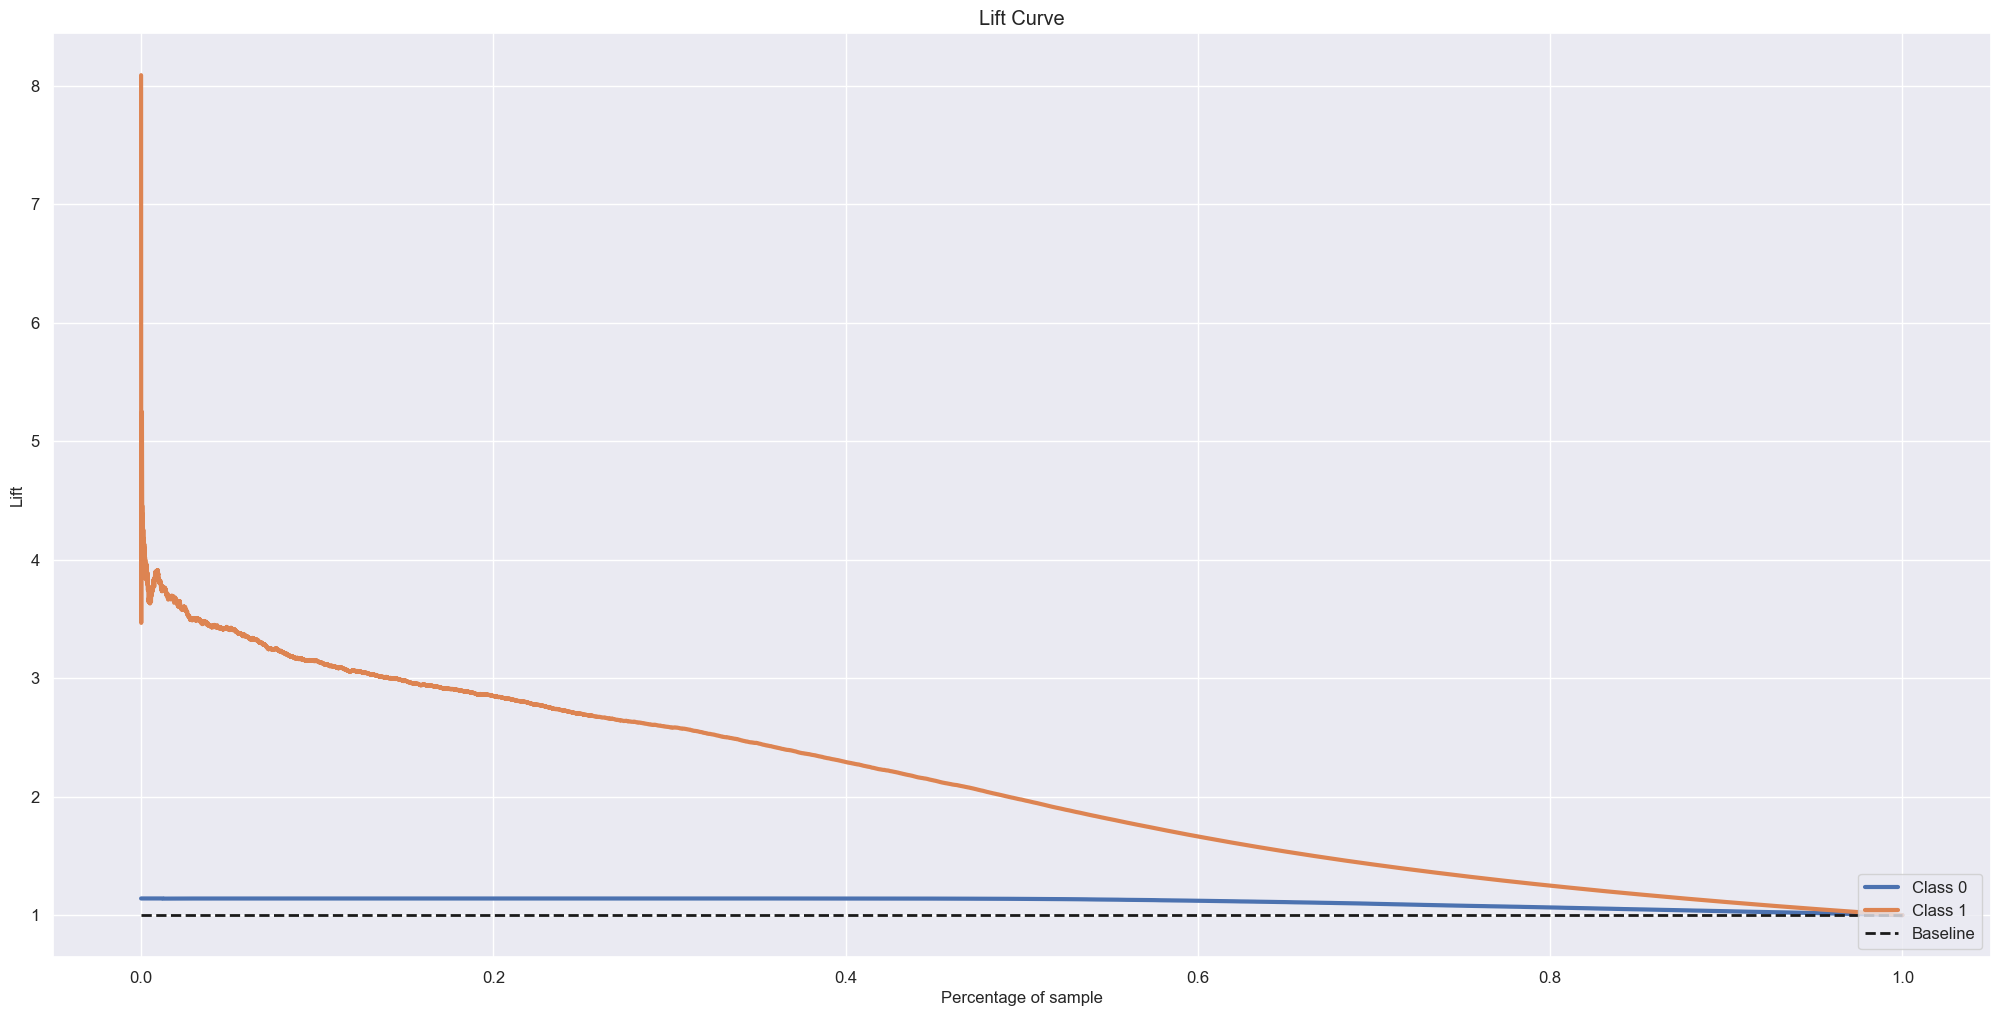

In [18]:
# model definition
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              verbosity=0).fit(x_train,y_train)

pickle.dump(model_xgb, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/model_xgb.pkl','wb') )

# model prediction
yhat_xgb = model_xgb.predict_proba(x_val)

model_rank_5 = model_results (model_xgb, "XGBoost Classifier", x_val, y_val, 20000 )

In [19]:
model_rank_5

,Model,Precision_at_k,Recall_at_k
0,XGBoost Classifier,0.33,0.71


## 7.6 Naive Bayes Classifier model


                     Model  Precision_at_k  Recall_at_k
0  Naive Bayes Classifier            0.30         0.64 



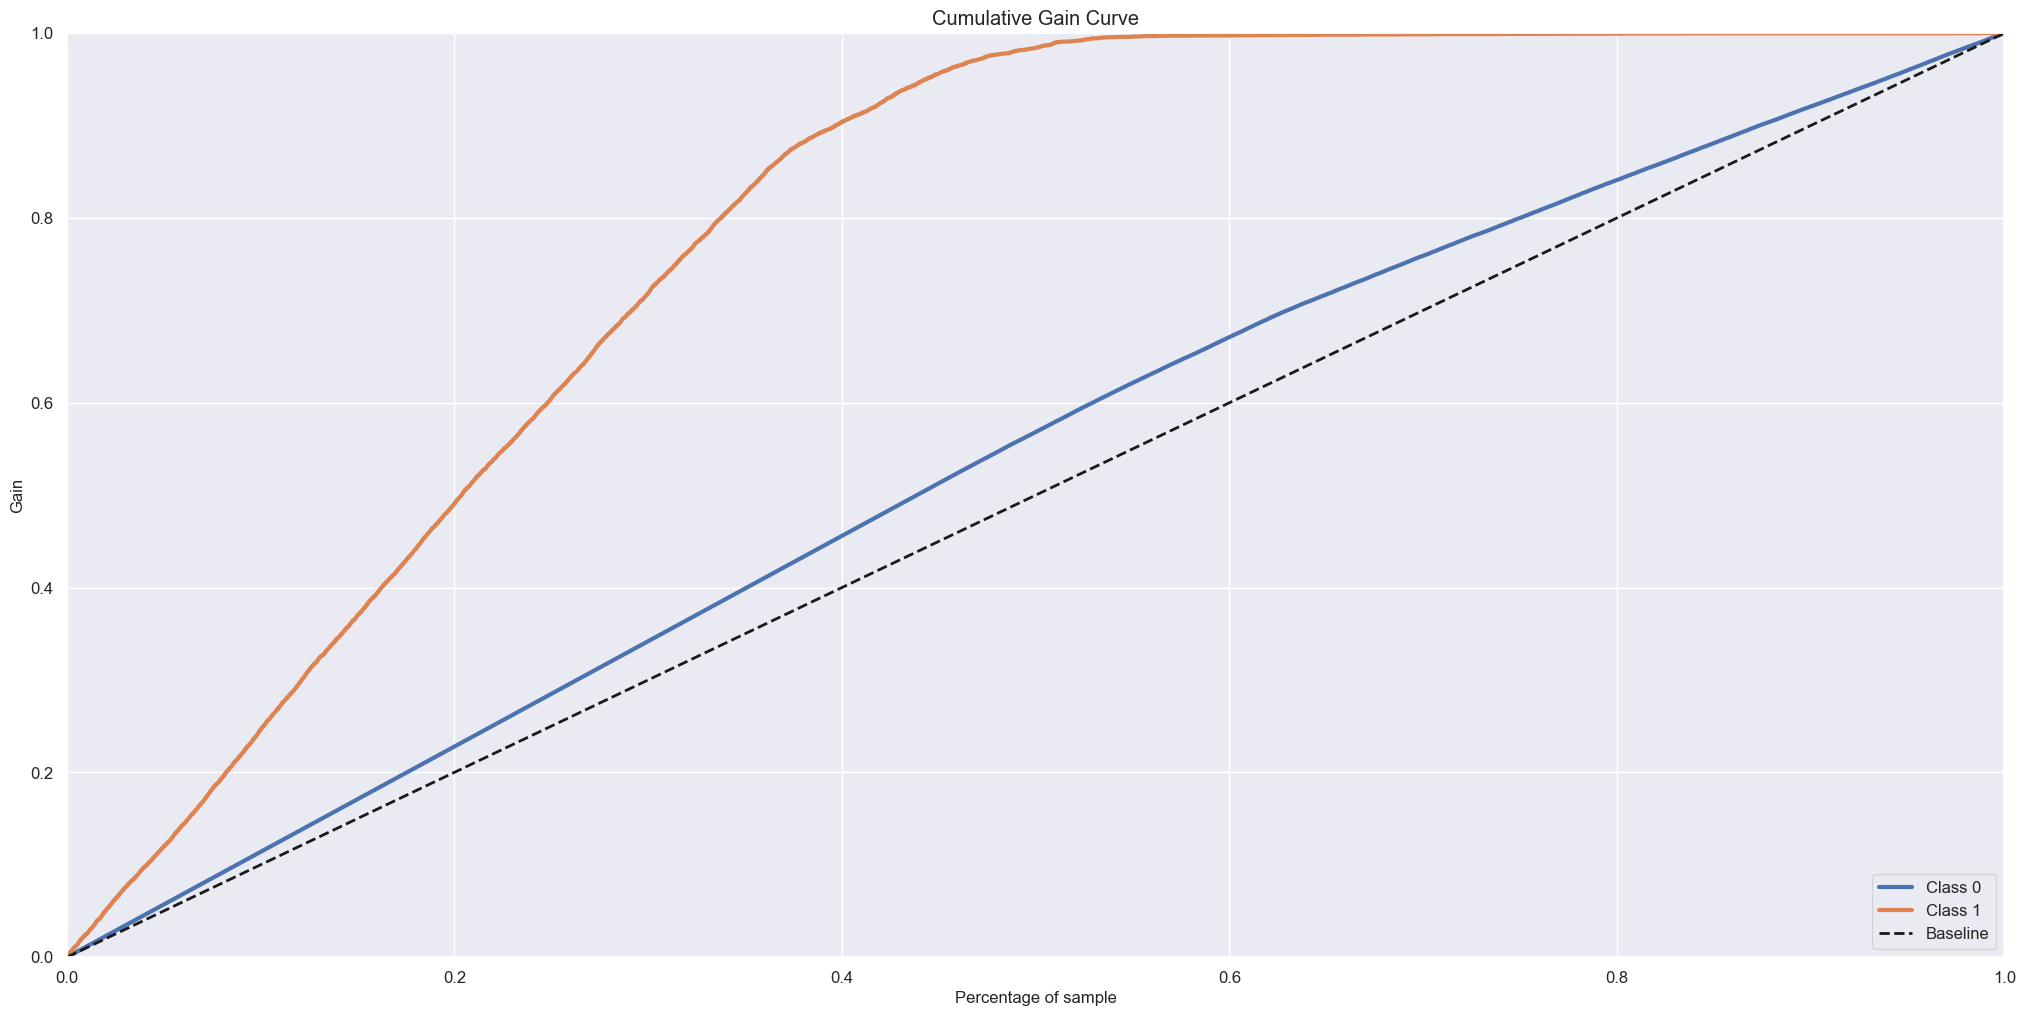

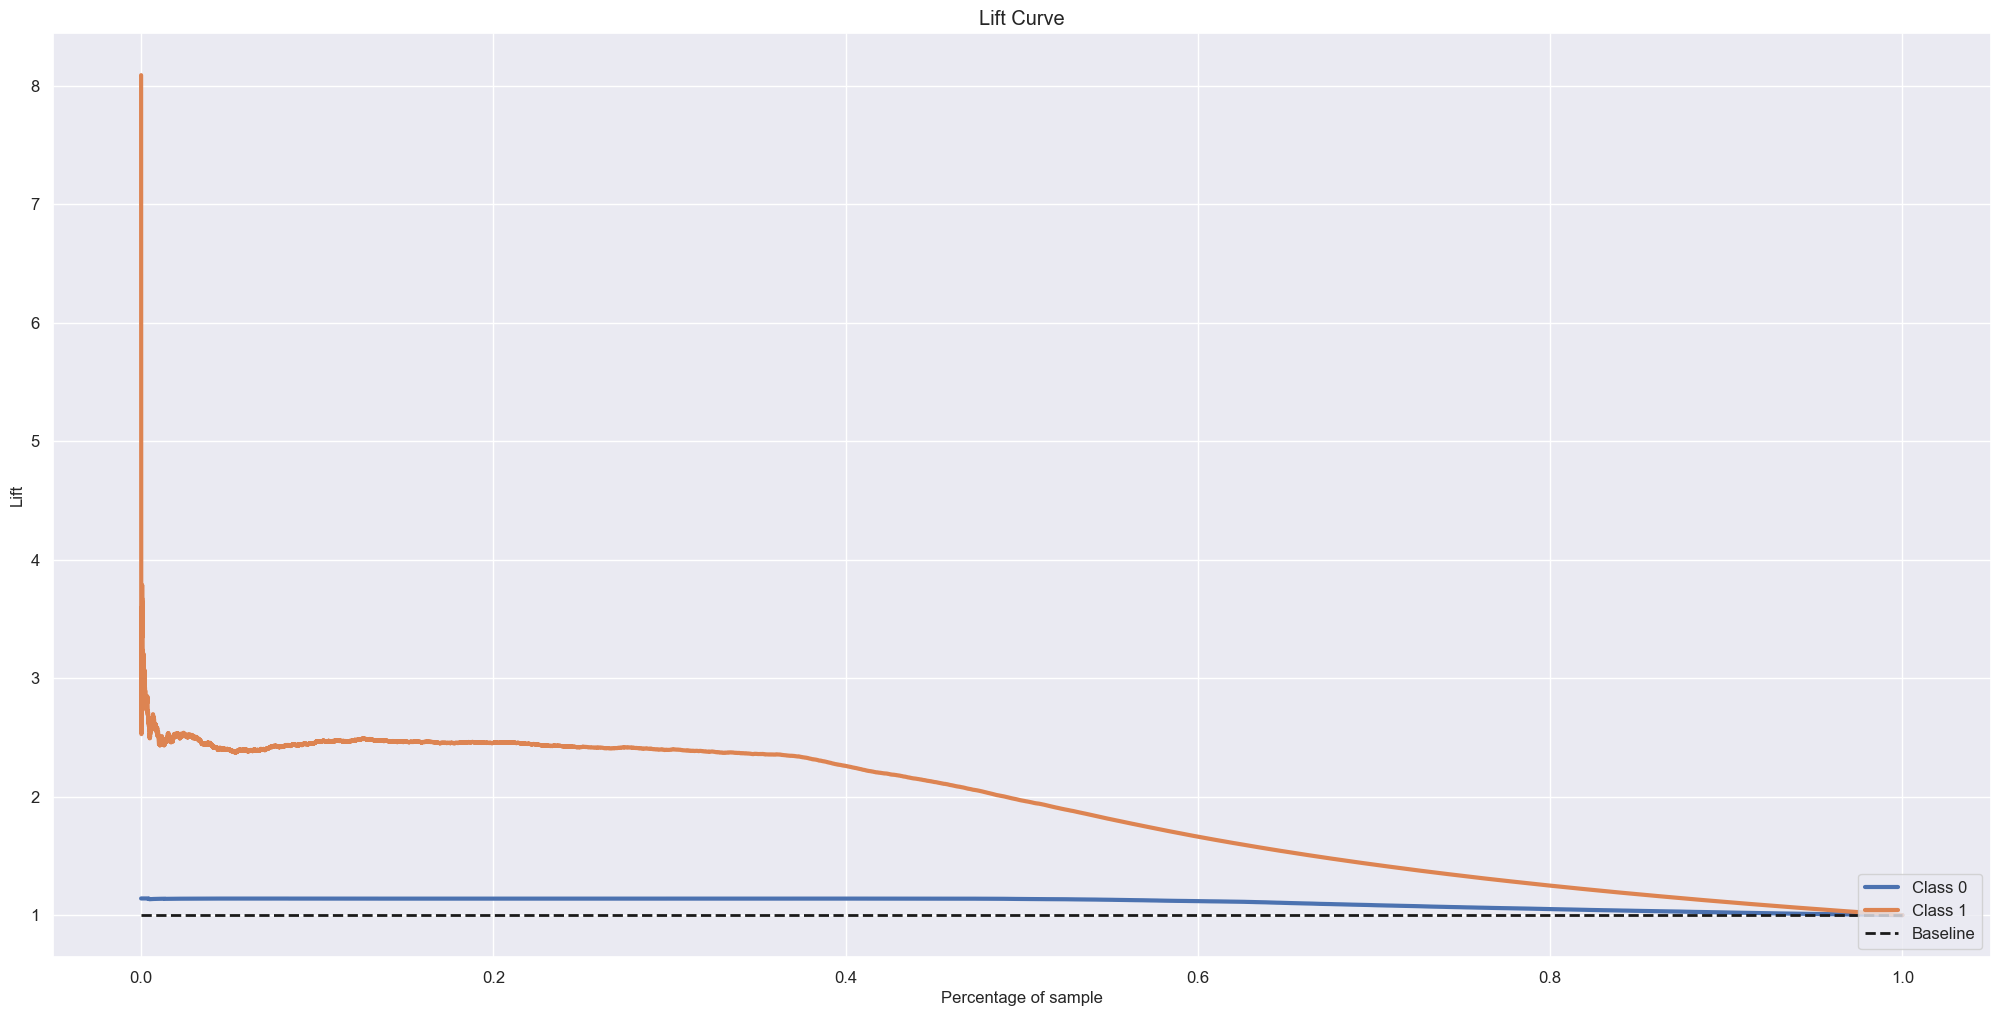

In [20]:
# model definition
model_nbc = GaussianNB().fit(x_train,y_train.values.ravel())
pickle.dump(model_nbc, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/model_nbc.pkl','wb') )

# model prediction
yhat_nbc = model_nbc.predict_proba(x_val)


model_rank_6 = model_results (model_nbc, "Naive Bayes Classifier", x_val, y_val, 20000 )

In [21]:
model_rank_6

,Model,Precision_at_k,Recall_at_k
0,Naive Bayes Classifier,0.30,0.64


## 7.7 Light Gradient Boosting Machine Classifier Model


              Model  Precision_at_k  Recall_at_k
0  LGBM Classifier            0.33         0.71 



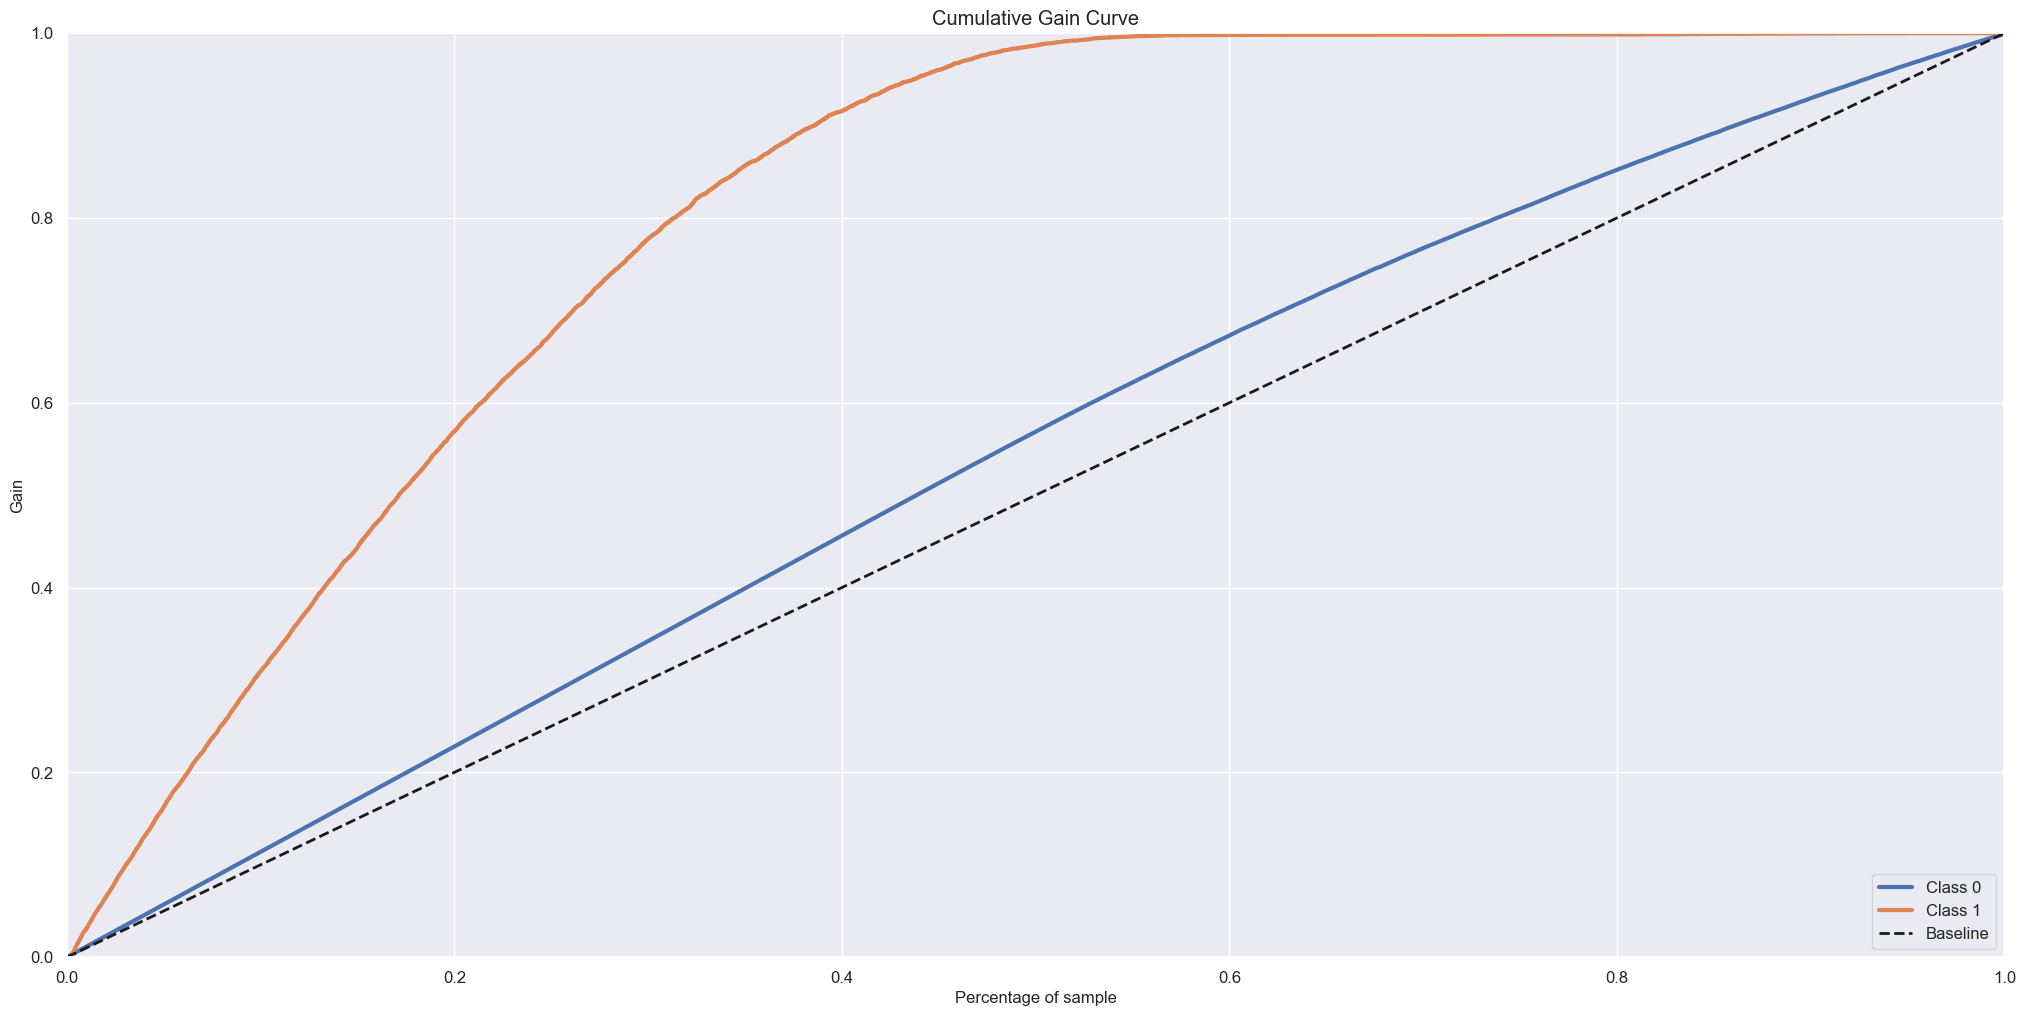

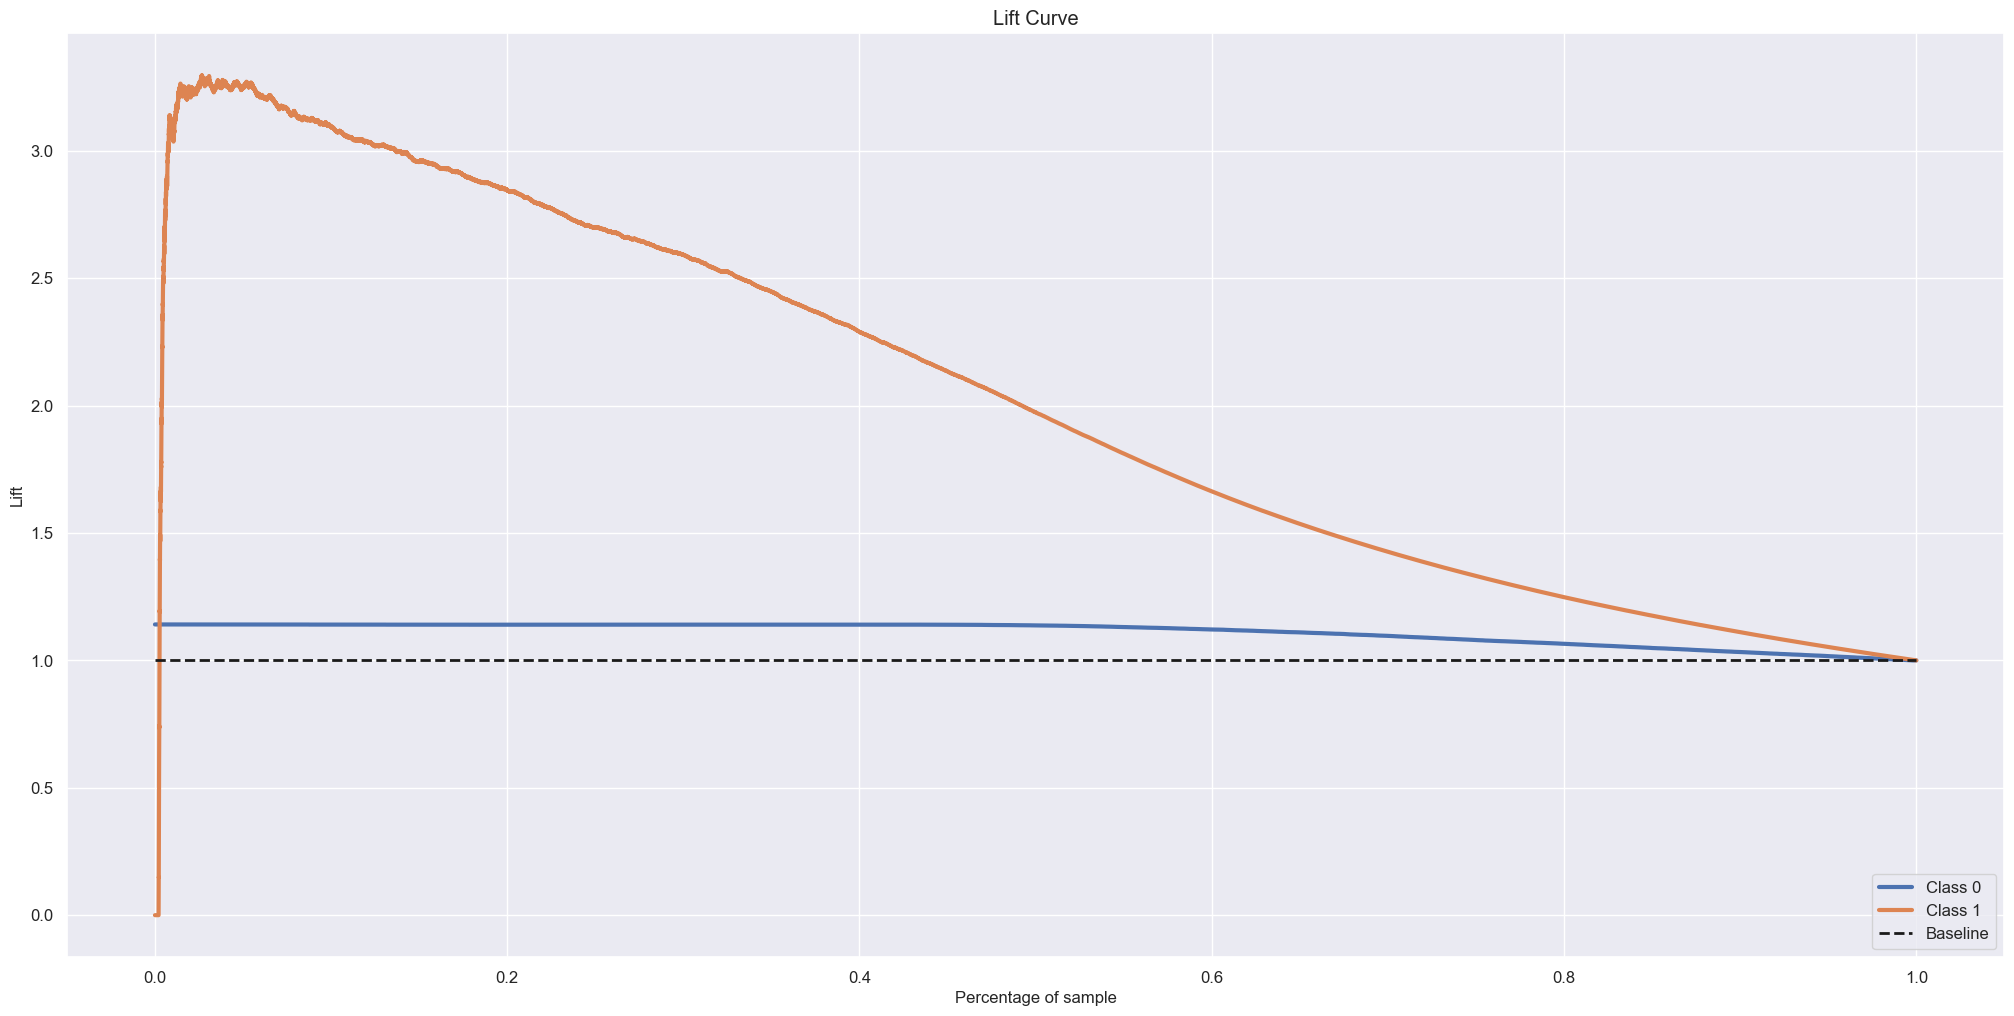

In [22]:
# model definition
model_lgbm = LGBMClassifier().fit(x_train,y_train.values.ravel())
pickle.dump(model_lgbm, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/model_lgbm.pkl','wb') )

# model prediction
yhat_lgbm = model_lgbm.predict_proba(x_val)

model_rank_7 = model_results (model_lgbm, "LGBM Classifier", x_val, y_val, 20000 )

In [23]:
model_rank_7

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.33,0.71


## 7.8 CatBoost Classifier

/home/deivison/Documentos/projetos/pa_04/venv_pa_04/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,



                   Model  Precision_at_k  Recall_at_k
0  CatBoosts Classifier            0.33         0.70 



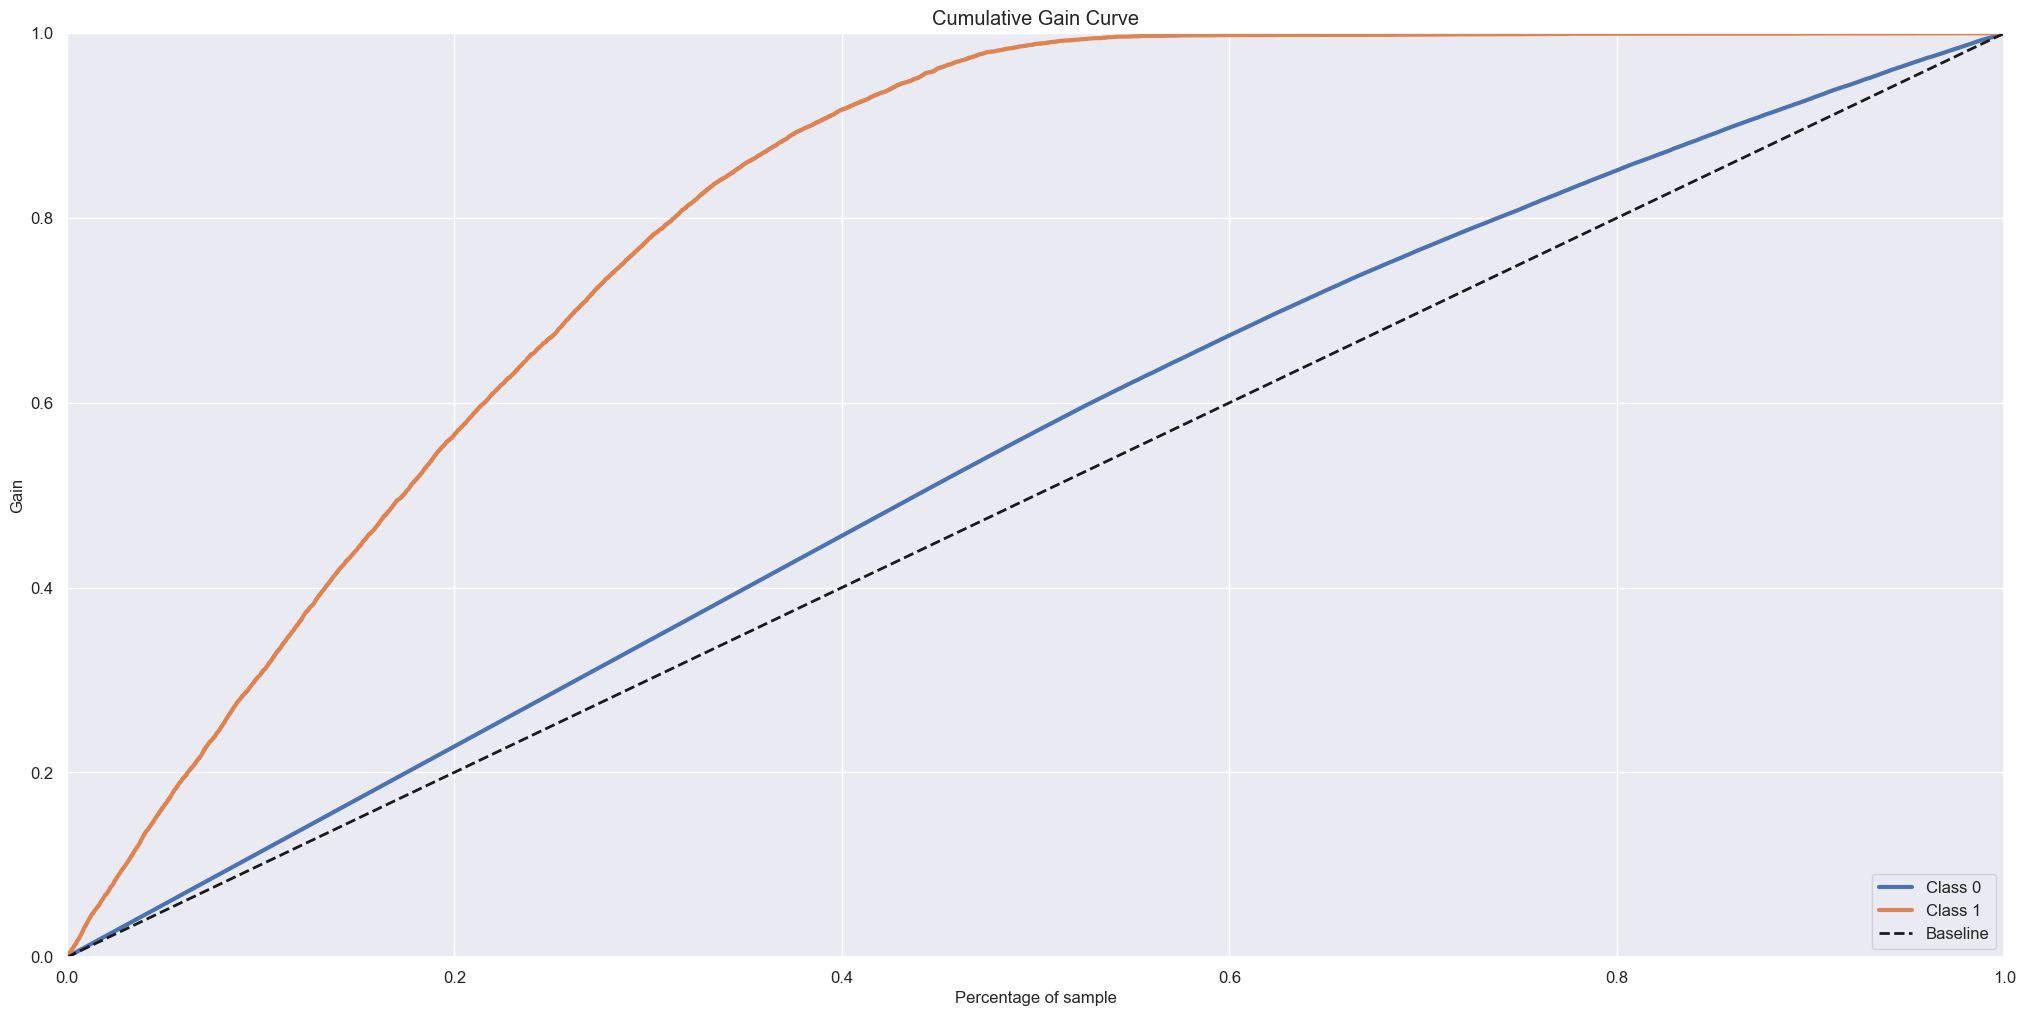

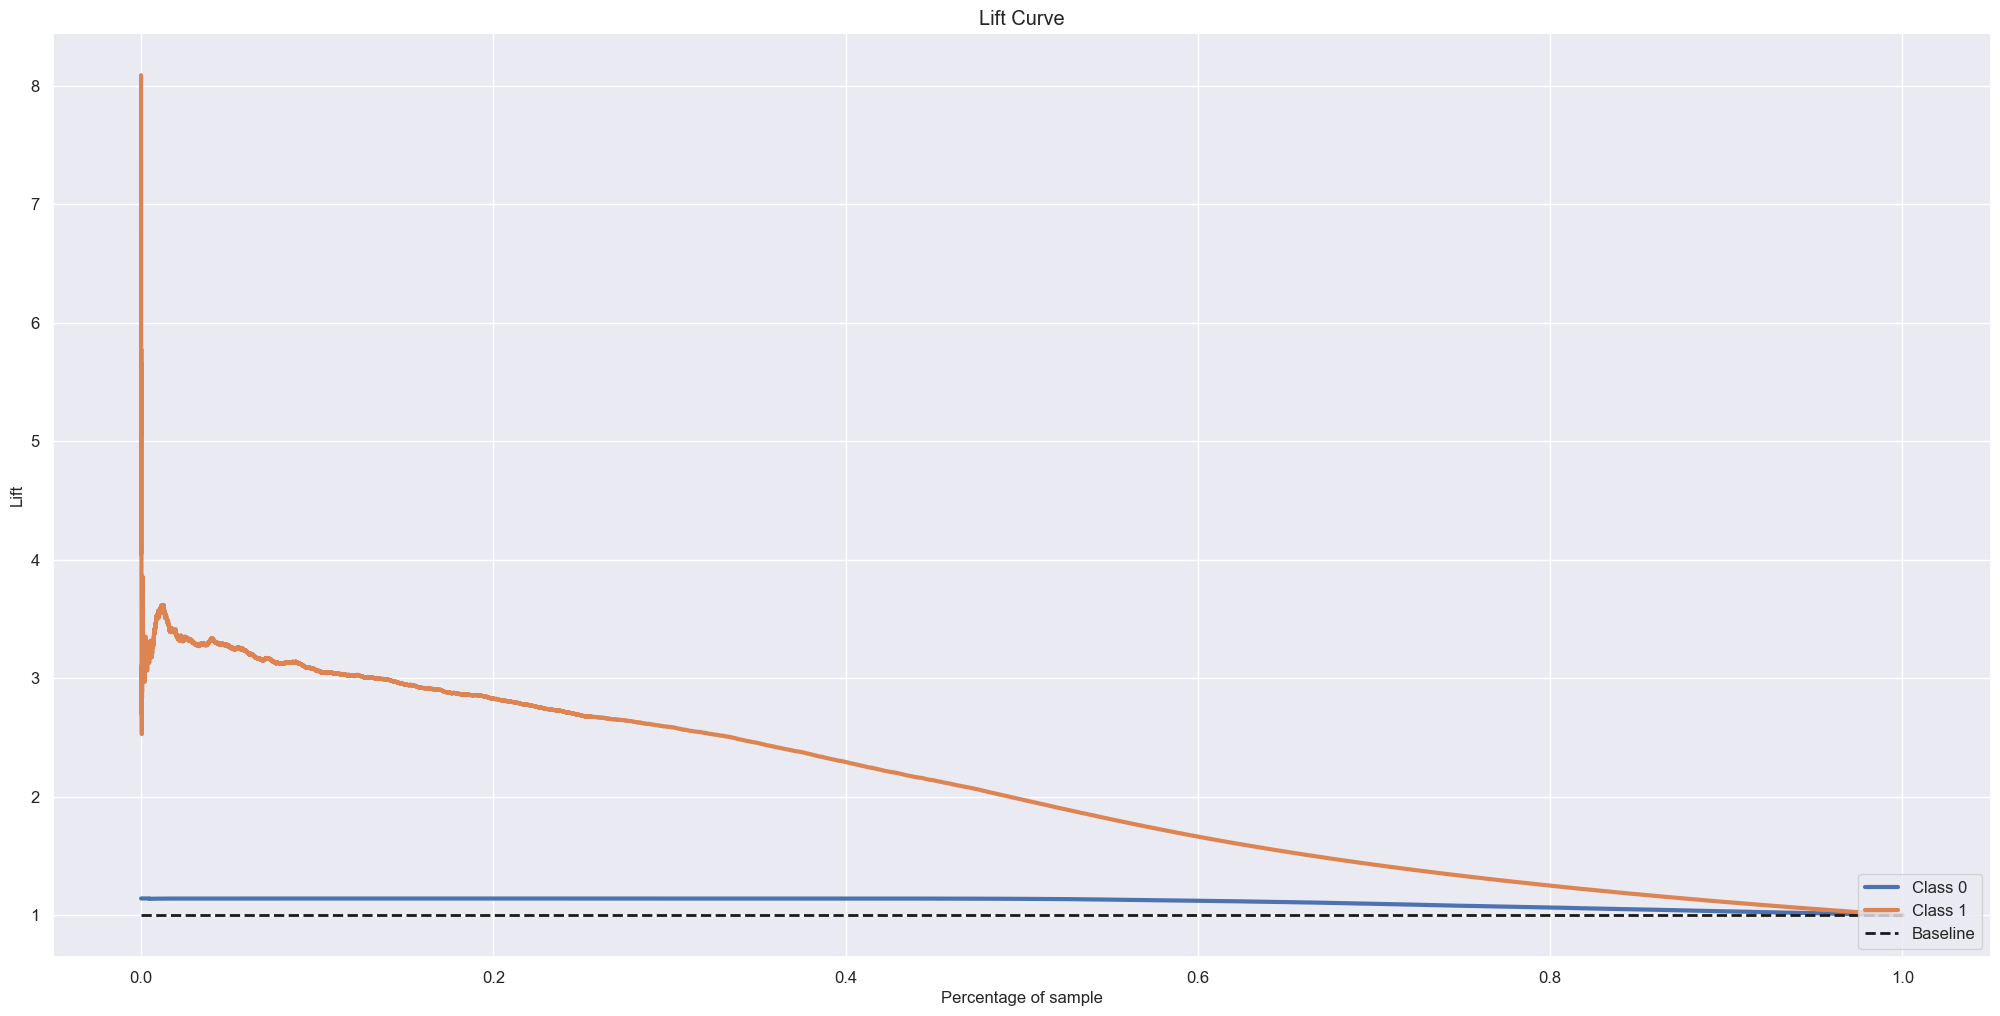

In [24]:
# model definition
model_cat =  CatBoostClassifier(
    n_estimators=1000, 
    learning_rate=0.1,
    logging_level = 'Silent').fit(x_train,y_train.values.ravel())
pickle.dump(model_cat, open('/home/deivison/Documentos/projetos/pa_04/pickle/models/model_cat.pkl','wb') )

# model prediction
yhat_cat = model_cat.predict_proba(x_val)

model_rank_8 = model_results (model_cat, "CatBoosts Classifier", x_val, y_val, 20000 )

In [25]:
model_rank_8

,Model,Precision_at_k,Recall_at_k
0,CatBoosts Classifier,0.33,0.70


## 7.8 Compare Model's Performance

In [26]:
res_total = pd.concat([model_rank_1, model_rank_2, model_rank_3, model_rank_4, model_rank_5, model_rank_6, model_rank_7, model_rank_8], axis=0)
res_total.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)

,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.33,0.71
1,XGBoost Classifier,0.33,0.71
2,CatBoosts Classifier,0.33,0.70
3,Random Forest Classifier,0.31,0.66
4,Extra Trees Classifier,0.30,0.65
5,Naive Bayes Classifier,0.30,0.64
6,KNN Classifier,0.29,0.63
7,Logistic Regression Classifier,0.29,0.62


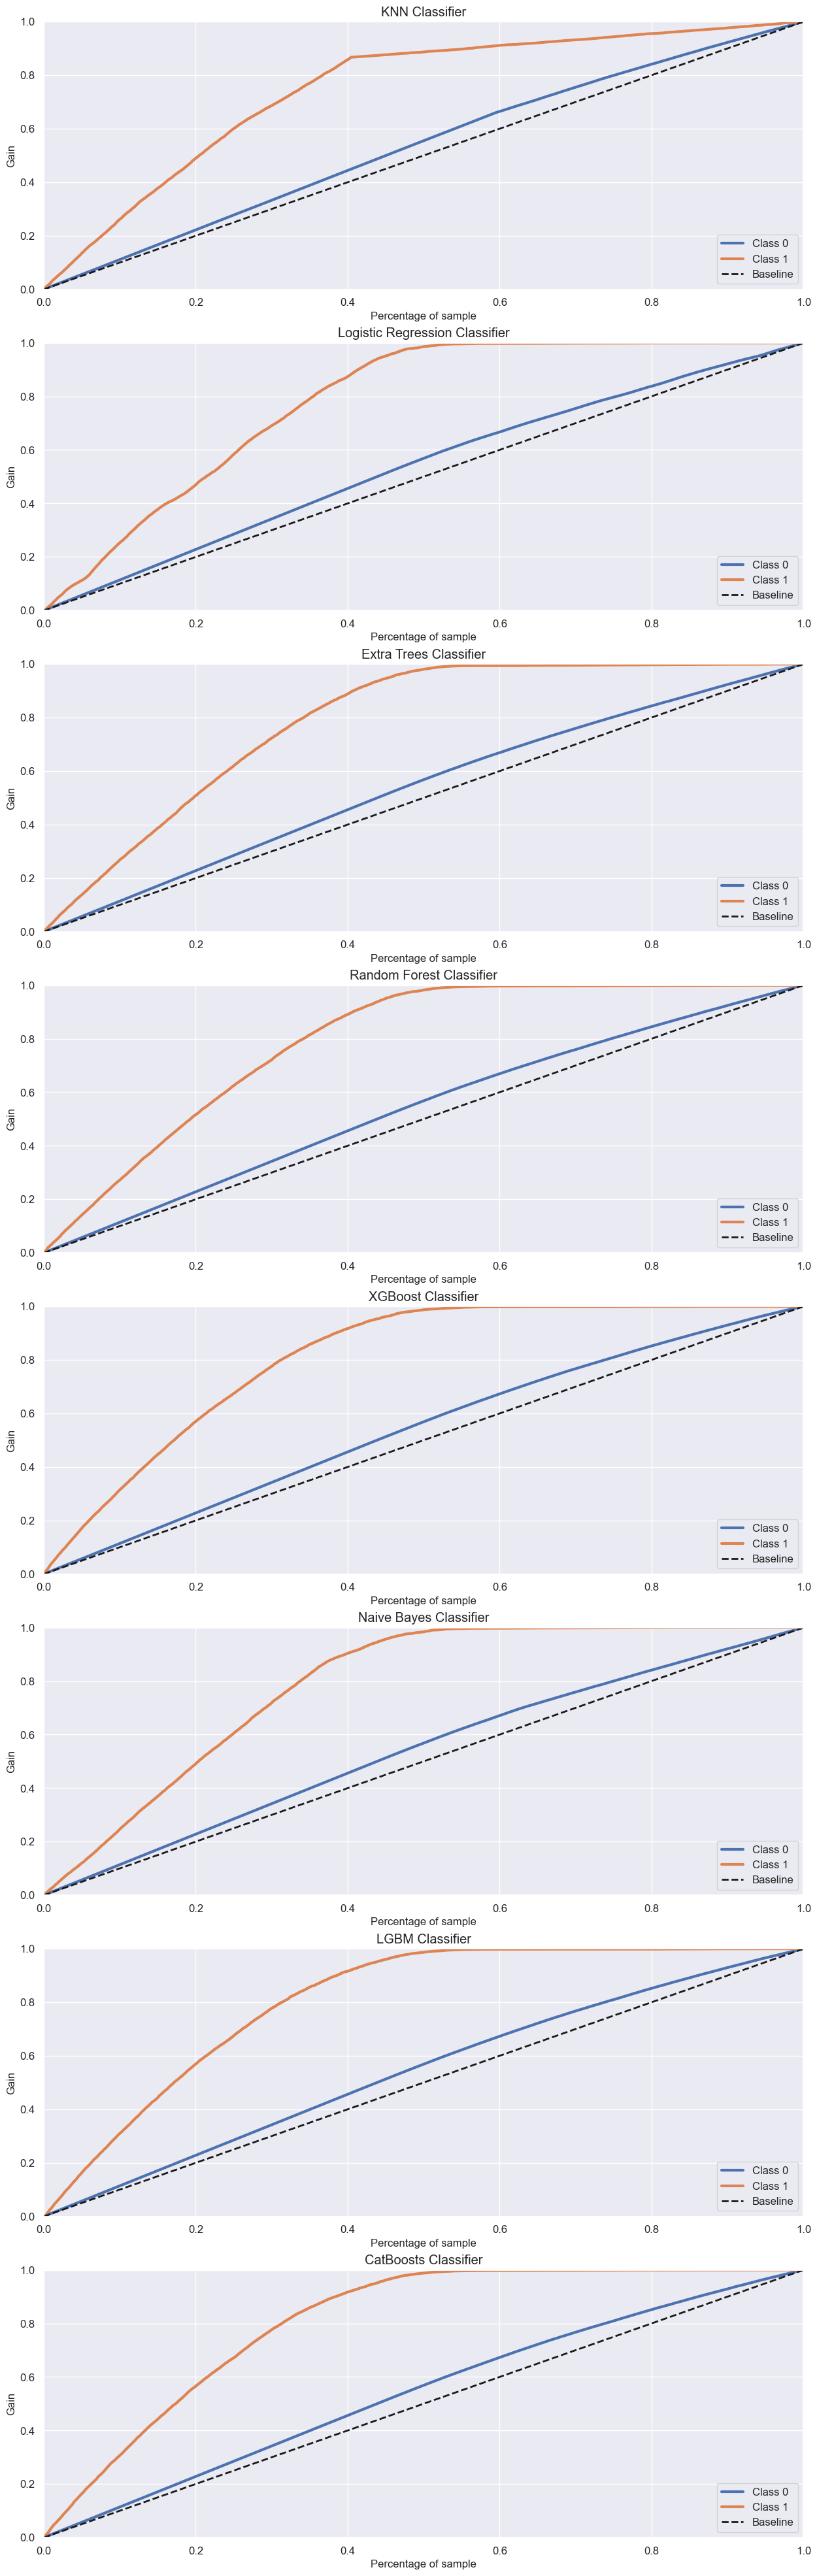

In [27]:
# create a figure object
fig = plt.figure( figsize = (15, 50) )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 8, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )
ax2 = fig.add_subplot( specs[ 1, 0 ] )
ax3 = fig.add_subplot( specs[ 2, 0 ] )
ax4 = fig.add_subplot( specs[ 3, 0 ] )
ax5 = fig.add_subplot( specs[ 4, 0 ] )
ax6 = fig.add_subplot( specs[ 5, 0 ] )
ax7 = fig.add_subplot( specs[ 6, 0 ] )
ax8 = fig.add_subplot( specs[ 7, 0 ] )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn,  title = 'KNN Classifier',                 ax = ax1    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr,   title = 'Logistic Regression Classifier', ax = ax2    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et,   title = 'Extra Trees Classifier',         ax = ax3    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf,   title = 'Random Forest Classifier',       ax = ax4    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb,  title = 'XGBoost Classifier',             ax = ax5    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_nbc,  title = 'Naive Bayes Classifier',         ax = ax6    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm, title = 'LGBM Classifier',                ax = ax7    )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_cat,  title = 'CatBoosts Classifier',           ax = ax8   );

## 7.9 Cross validation

In [28]:
#def cross_validation( num_folds, model_name, model, x_train, y_train, k):

In [29]:
models_performance_cv = pd.DataFrame({'Model':[], 'Precision_at_k': [], 'Recall_at_k': []}) 

aux1  = cross_validation ( 5, 'KNN CV',  knn_model,  x_train, y_train, 20000)
models_performance_cv  = pd.concat([ models_performance_cv, aux1 ],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'LR CV',   lr_model,   x_train, y_train, 20000) 
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'ET CV',   et,         x_train, y_train, 20000)
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'RF CV',   rf,         x_train, y_train, 20000)
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'XGB CV',  model_xgb,  x_train, y_train, 20000)
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'NBC CV',  model_nbc,  x_train, y_train, 20000) 
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'LGBM CV', model_lgbm, x_train, y_train, 20000)
models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)
aux1  = cross_validation ( 5, 'CATB CV', model_cat, x_train, y_train, 20000)

models_performance_cv  = pd.concat([models_performance_cv, aux1],ignore_index = True, axis=0)

/home/deivison/Documentos/projetos/pa_04/venv_pa_04/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/deivison/Documentos/projetos/pa_04/venv_pa_04/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/deivison/Documentos/projetos/pa_04/venv_pa_04/lib/python3.10/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/deivison/Documentos/pr

In [30]:
aux1

,Model,Precision_at_k,Recall_at_k
0,CATB CV,0.2908 +/- 0.0015,0.8916 +/- 0.0045


In [31]:
models_performance_cv

,Model,Precision_at_k,Recall_at_k
0,KNN CV,0.265 +/- 0.002,0.8126 +/- 0.0063
1,LR CV,0.2706 +/- 0.0016,0.8306 +/- 0.0052
2,ET CV,0.276 +/- 0.0014,0.8466 +/- 0.0044
3,RF CV,0.2812 +/- 0.0015,0.8624 +/- 0.0048
4,XGB CV,0.2908 +/- 0.0013,0.8924 +/- 0.0039
5,NBC CV,0.2842 +/- 0.0013,0.8716 +/- 0.004
6,LGBM CV,0.2912 +/- 0.0012,0.8936 +/- 0.004
7,CATB CV,0.2908 +/- 0.0015,0.8916 +/- 0.0045


In [32]:
#models_performance_cv = models_performance_cv.sort_values('Recall_at_k', ascending = False).reset_index(drop=True)
pickle.dump( models_performance_cv, open( '/home/deivison/Documentos/projetos/pa_04/pickle/cross_validation.pkl', 'wb' ) )
models_performance_cv

,Model,Precision_at_k,Recall_at_k
0,KNN CV,0.265 +/- 0.002,0.8126 +/- 0.0063
1,LR CV,0.2706 +/- 0.0016,0.8306 +/- 0.0052
2,ET CV,0.276 +/- 0.0014,0.8466 +/- 0.0044
3,RF CV,0.2812 +/- 0.0015,0.8624 +/- 0.0048
4,XGB CV,0.2908 +/- 0.0013,0.8924 +/- 0.0039
5,NBC CV,0.2842 +/- 0.0013,0.8716 +/- 0.004
6,LGBM CV,0.2912 +/- 0.0012,0.8936 +/- 0.004
7,CATB CV,0.2908 +/- 0.0015,0.8916 +/- 0.0045


# 8.0 Hyperparameter Fine Tuning

In [33]:
# def cross_validation(data, models_performance, num_folds, model_name, model, x_train, y_train, k):

In [34]:
final_result_lg = pd.DataFrame(columns={'Model':[], "Precision_at_k": [], "Recall_at_k": []})

In [35]:
lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),          
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

MAX_EVAL = 5


for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:random.sample(v, 1)[0] for k, v in lgbm_parameter.items()}
    #print the selected ones
    print(hp)
    #model
    model_lgbm=LGBMClassifier(  objective = 'binary',
                                num_leaves=hp['num_leaves'],
                                max_depth=hp['max_depth'],
                                min_split_gain=hp['min_split_gain'],
                                subsample=hp['subsample'],
                                colsample_bytree=hp['colsample_bytree'])
    
    result = cross_validation ( 5, 'LGBM Classifier', model_lgbm, x_train, y_train, 20000) 
    iter_nr = pd.Series([i], name='Iter_nr')
    
    result_w_nr = pd.concat([result, iter_nr], axis=1  )
    final_result_lg = pd.concat([final_result_lg, result_w_nr], axis = 0,  ignore_index=True, keys=('Model','Precision_at_k','Recall_at_k') )
    print(iter_nr)
    print(final_result_lg)
    

#final_result_lg = final_result_lg.T
#final_result_lg = final_result_lg.iloc[4::,:]
final_result_lg = final_result_lg.sort_values('Recall_at_k', ascending = False)

pickle.dump( final_result_lg, open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_2/lgbm_tuning_10.pkl', 'wb' ) )
final_result_lg

{'num_leaves': 90, 'max_depth': 10, 'min_split_gain': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.1}
0    0
Name: Iter_nr, dtype: int64
             Model     Precision_at_k      Recall_at_k  Iter_nr
0  LGBM Classifier  0.2898 +/- 0.0012  0.889 +/- 0.004     0.00
{'num_leaves': 15, 'max_depth': 10, 'min_split_gain': 0.1, 'subsample': 1, 'colsample_bytree': 1}
0    1
Name: Iter_nr, dtype: int64
             Model     Precision_at_k        Recall_at_k  Iter_nr
0  LGBM Classifier  0.2898 +/- 0.0012    0.889 +/- 0.004     0.00
1  LGBM Classifier  0.2914 +/- 0.0012  0.8932 +/- 0.0033     1.00
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.01, 'subsample': 1, 'colsample_bytree': 1}
0    2
Name: Iter_nr, dtype: int64
             Model     Precision_at_k        Recall_at_k  Iter_nr
0  LGBM Classifier  0.2898 +/- 0.0012    0.889 +/- 0.004     0.00
1  LGBM Classifier  0.2914 +/- 0.0012  0.8932 +/- 0.0033     1.00
2  LGBM Classifier   0.291 +/- 0.0017   0.893 +/- 0.0045     2.00
{'num_l

,Model,Precision_at_k,Recall_at_k,Iter_nr
4,LGBM Classifier,0.2914 +/- 0.0012,0.894 +/- 0.0035,4.00
1,LGBM Classifier,0.2914 +/- 0.0012,0.8932 +/- 0.0033,1.00
2,LGBM Classifier,0.291 +/- 0.0017,0.893 +/- 0.0045,2.00
3,LGBM Classifier,0.29 +/- 0.0014,0.89 +/- 0.0038,3.00
0,LGBM Classifier,0.2898 +/- 0.0012,0.889 +/- 0.004,0.00


In [36]:
# como colocar os param em lista
#param_tuned = 'num_leaves': 45, 'max_depth': 10, 'min_split_gain': 0.01, 'subsample': 1, 'colsample_bytree': 1

final_result_lgbm = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_2/lgbm_tuning_10.pkl', 'rb' ) )

final_result_lgbm

,Model,Precision_at_k,Recall_at_k,Iter_nr
4,LGBM Classifier,0.2914 +/- 0.0012,0.894 +/- 0.0035,4.00
1,LGBM Classifier,0.2914 +/- 0.0012,0.8932 +/- 0.0033,1.00
2,LGBM Classifier,0.291 +/- 0.0017,0.893 +/- 0.0045,2.00
3,LGBM Classifier,0.29 +/- 0.0014,0.89 +/- 0.0038,3.00
0,LGBM Classifier,0.2898 +/- 0.0012,0.889 +/- 0.004,0.00


In [37]:
## Model 


              Model  Precision_at_k  Recall_at_k
0  LGBM Classifier            0.33         0.71 



,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.33,0.71


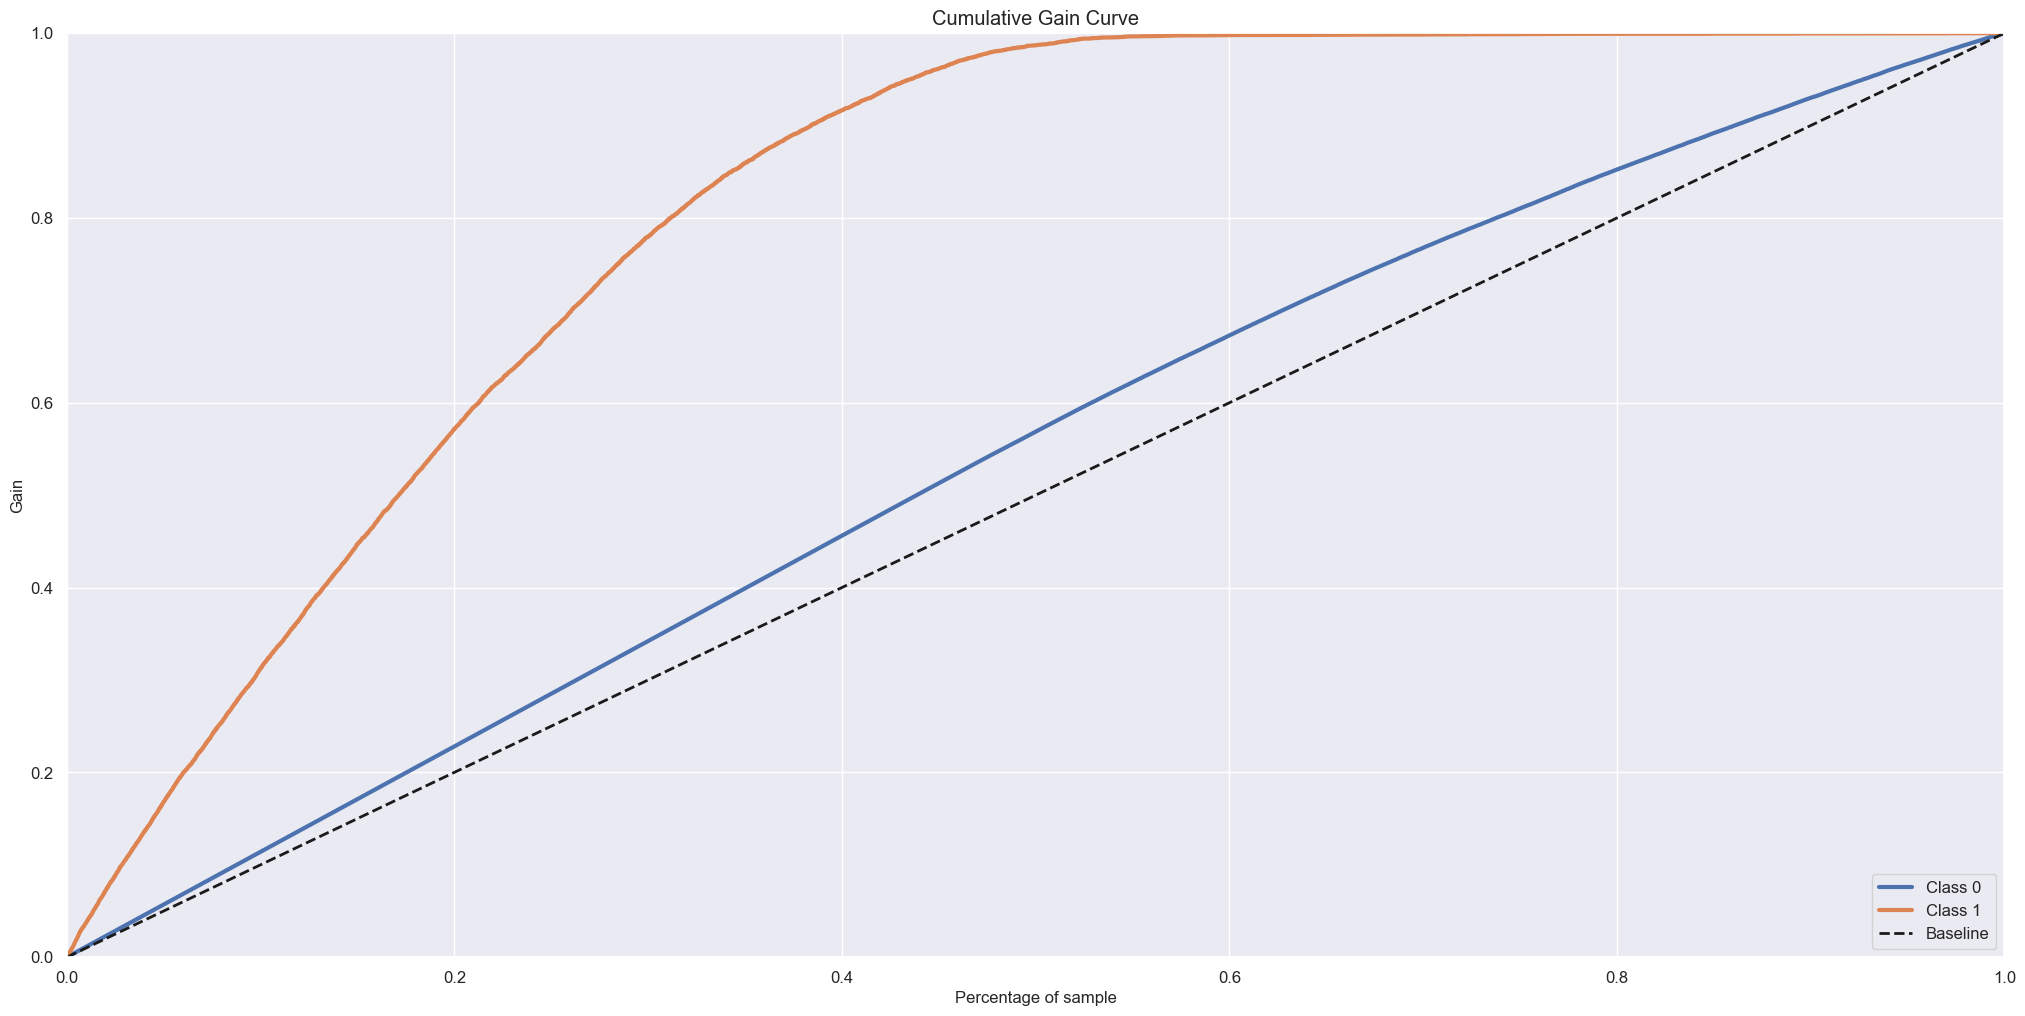

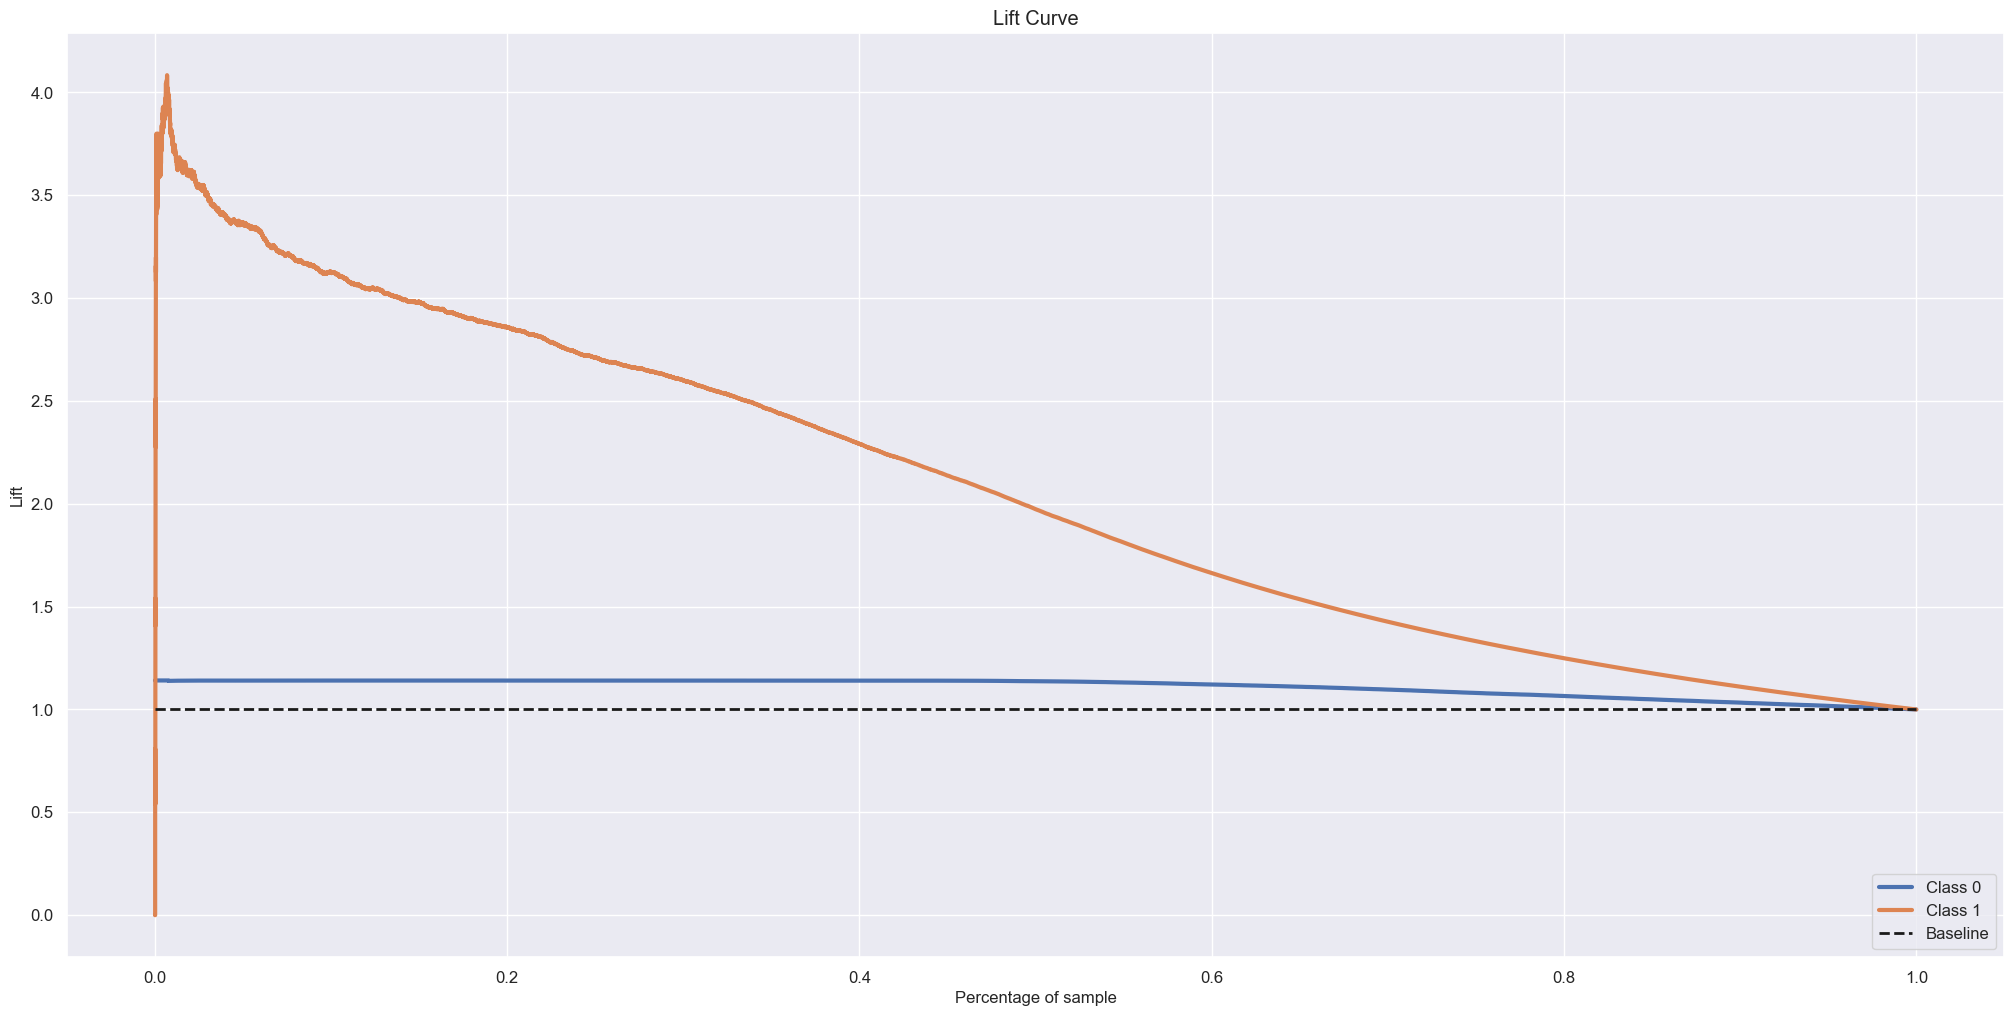

In [38]:
# {'num_leaves': 45, 'max_depth': 10, 'min_split_gain': 0.01, 'subsample': 1, 'colsample_bytree': 1}

# model definition
model_lgbm = LGBMClassifier( objective = 'binary',num_leaves=45,
                           max_depth=10, min_split_gain=0.01, 
                           subsample=1, colsample_bytree=1)
model_lgbm.fit(x_train,y_train.values.ravel() )

# model prediction
yhat_proba_lgbm = model_lgbm.predict_proba(x_val)

result = model_results(model_lgbm, "LGBM Classifier", x_val, y_val, 20000 )
result

# 9.0 Business Performance

In [39]:
# copy dataframe
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_val = x_validation[ cols_selected ]

df9 = x_val.copy()
df9['id'] = x_validation['id'].copy()
df9['response'] = y_val.copy()

# propensity score 1D
df9['score'] = yhat_proba_lgbm[:, 1].tolist()


# sort clients by propensity score
df9 = df9.sort_values( 'score', ascending=False ).reset_index(drop=True)

# Rank
df9['ranking'] = df9.index+1

In [40]:
df9.head(20)

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel,id,response,score,ranking
0,-1.62,0.91,0.02,0.12,1,1,0.06,311869,0,1.00,1
1,-0.28,0.95,0.05,0.10,0,1,0.36,180634,0,0.89,2
2,-0.36,0.57,0.34,0.11,0,1,0.19,109721,0,0.83,3
3,-0.36,0.63,0.26,0.11,0,1,0.19,373840,0,0.75,4
4,-0.36,0.58,0.26,0.11,0,1,0.19,333123,0,0.75,5
5,-0.37,0.47,0.32,0.11,0,1,0.19,153782,0,0.75,6
6,0.84,0.25,0.32,0.21,0,1,0.00,104866,0,0.73,7
7,0.88,0.25,0.25,0.10,0,1,0.36,30307,0,0.71,8
8,-0.34,1.00,0.22,0.13,1,0,0.02,244525,0,0.56,9
9,-0.43,0.36,0.20,0.12,1,0,0.02,217975,1,0.55,10


### Análise Conjunto de validação

In [41]:
# 20 mil clientes correspondem a 26.50 % do conjunto de validação (20000/75459) --> valor k do problema = 20000 clientes
k = 20000
customer_proportion_k_v = k / df9.shape[0]
customer_proportion_k_v

0.2650445937528989

In [42]:
# total de clientes conjunto de validação
total_customers_v = df9.shape[0]
total_customers_v

75459

In [43]:
# total de clientes interessados no conjunto de validação
total_interested_customers = df9['response'].sum()
total_interested_customers

9328

In [44]:
# percentual de clientes interessados no conjunto de validação
total_interested_customers_percentual = ( (df9['response'].sum()) / df9.shape[0] ) * 100
total_interested_customers_percentual

12.361679852635206

In [45]:
# proporção de clientes interessados até posição 20 mil do conjunto de validação
#total_interested_customers_until_k = k*(percentual/100)
total_interested_customers_until_k = k*(total_interested_customers_percentual/100)
total_interested_customers_until_k

2472.3359705270414

In [46]:
# percentual de clientes interessados do total de clientes interessados ordenados pelo modelo até posição 20 mil
recall_random = (total_interested_customers_until_k) / df9['response'].sum()
recall_random

0.26504459375289896

### Lista rankeada pelo modelo 

In [47]:
# Total de clientes interessados até a posição 20 mil da lista ordenada pelo modelo
interested_customers_ordered_until_k = df9['response'].loc[df9['ranking']<20000].sum()
interested_customers_ordered_until_k

6616

In [48]:
# percentual de clientes interessados do total de clientes interessados ordenados pelo modelo até posição 20 mil
recall_k = (df9['response'].loc[df9['ranking']<20000].sum()) / df9['response'].sum()
recall_k

0.70926243567753

In [49]:
# Total de clientes interessados até a posição 40 mil da lista ordenada pelo modelo
df9['response'].loc[df9['ranking']<40000].sum()

9279

In [50]:
# percentual de clientes interessados do total de clientes interessados ordenados pelo modelo até posição 40 mil
(df9['response'].loc[df9['ranking']<40000].sum()) / df9['response'].sum()

0.9947469982847341

### Resumo

O conjunto de dados de validação possui 75459 clientes.
* Sendo que 9328 respoderam que tinha interesse em contrar o seguro veícular.

Lista ordenada pelo modelo de machine Learning até a posição 20 mil
* Rankou 6616 clientes com interesse em contratar o seguro veícular dos 9328 clientes interessados existentes no conjunto de validação.
* Precisão de 33.08% (6616/20000)
* Recall 70.93% (6616/9328)

Probabilidade aleatória
* Clientes interessados 12,36% (9328/75459) do conjunto de dados de validação
* Valor esperado de clientes interessados até posição 20 mil = 2472 clientes (20000 * 12,36%)

Lift do modelo 
* Modelo ordenou 6616 clientes interessados até a posição 20 mil
* Diferença de 4144 clientes a mais que o valor esperado do modelo aleatório até a posição 20 mil
    * (6616-2472)
* Lift de 2.67 vezes que o modelo aleatório até a posição 20 mil
    * (6616/2472)

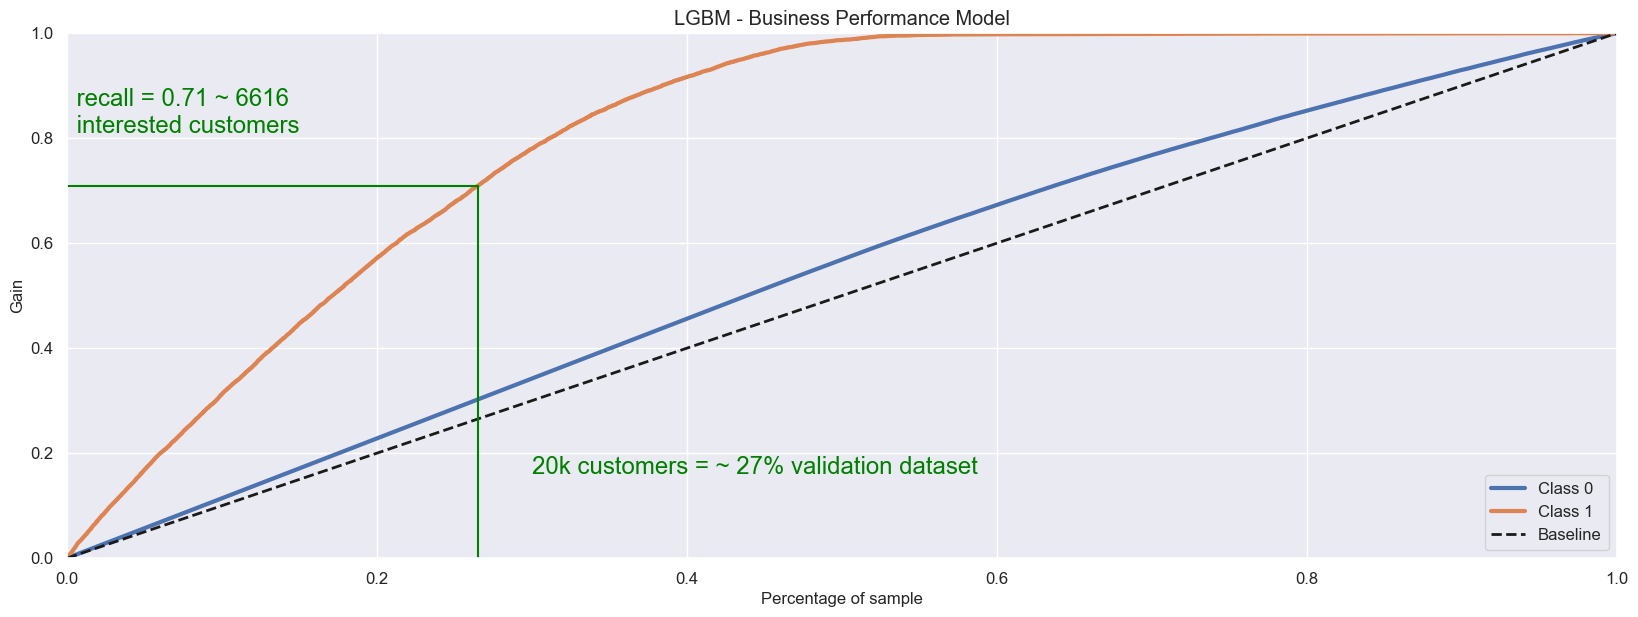

In [51]:
# create a figure object
fig = plt.figure( figsize = (20, 15) )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_proba_lgbm, title = 'LGBM - Business Performance Model', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( customer_proportion_k_v, ymax = recall_k, color = 'green', label = '20k' )
ax1.axhline( recall_k , xmax = customer_proportion_k_v, color = 'green' )

plt.text( 0.30 , 0.15 + 0.01, '20k customers = ~ 27% validation dataset', color = 'green', fontsize = 'x-large');
plt.text( 0.002 , 0.80 + 0.01, ' recall = 0.71 ~ 6616\n interested customers', color = 'green', fontsize = 'x-large');


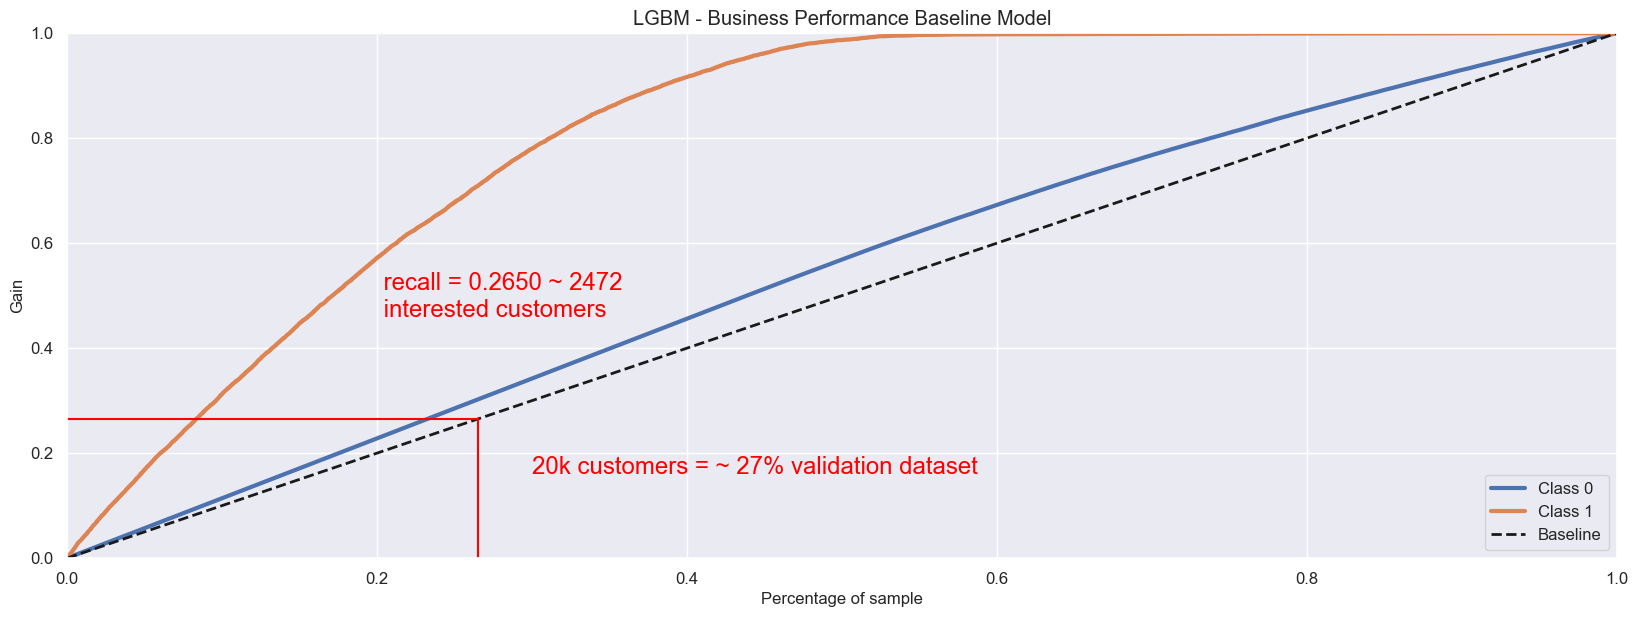

In [52]:
# create a figure object
fig = plt.figure( figsize = (20, 15) )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_proba_lgbm, title = 'LGBM - Business Performance Baseline Model', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( customer_proportion_k_v, ymax =recall_random, color = 'red', label = '20k' )
ax1.axhline( recall_random , xmax = customer_proportion_k_v, color = 'red' )

plt.text( 0.30 , 0.15 + 0.01, '20k customers = ~ 27% validation dataset', color = 'red', fontsize = 'x-large');
plt.text( 0.20 , 0.45 + 0.01, ' recall = 0.2650 ~ 2472\n interested customers', color = 'red', fontsize = 'x-large');

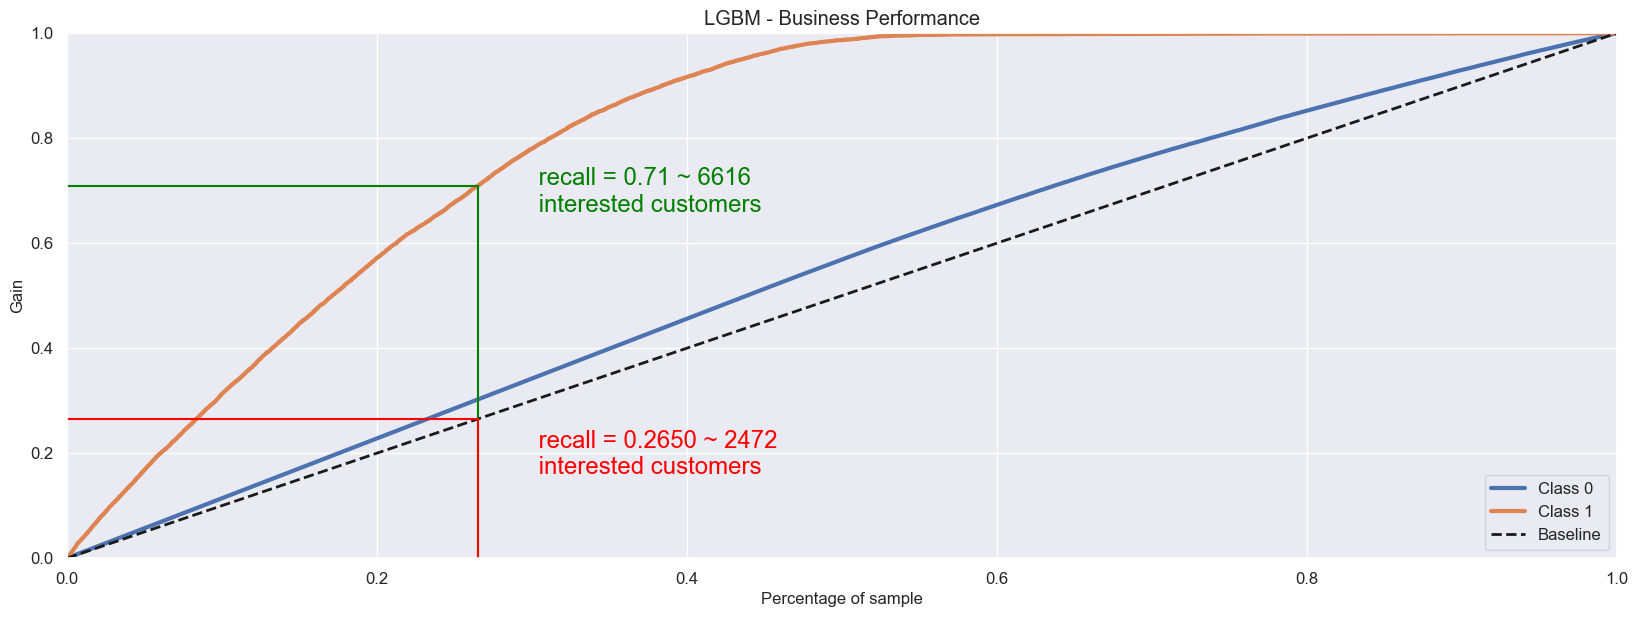

In [53]:
# create a figure object
fig = plt.figure( figsize = (20, 15) )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )

# plot accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_proba_lgbm, title = 'LGBM - Business Performance', ax = ax1 );


# add 20000 customers contacted line
ax1.axvline( customer_proportion_k_v, ymax = recall_k, color = 'green', label = '20k' )
ax1.axhline( recall_k , xmax = customer_proportion_k_v, color = 'green' )

#plt.text( 0.30 , 0.15 + 0.01, '20k customers = ~ 27% validation dataset', color = 'green', fontsize = 'x-large');
plt.text( 0.30 , 0.65 + 0.01, ' recall = 0.71 ~ 6616\n interested customers', color = 'green', fontsize = 'x-large');

ax1.axvline( customer_proportion_k_v, ymax =recall_random, color = 'red', label = '20k' )
ax1.axhline( recall_random , xmax = customer_proportion_k_v, color = 'red' )

#plt.text( 0.30 , 0.15 + 0.01, '20k customers = ~ 27% validation dataset', color = 'red', fontsize = 'x-large');
plt.text( 0.30 , 0.15 + 0.01, ' recall = 0.2650 ~ 2472\n interested customers', color = 'red', fontsize = 'x-large');

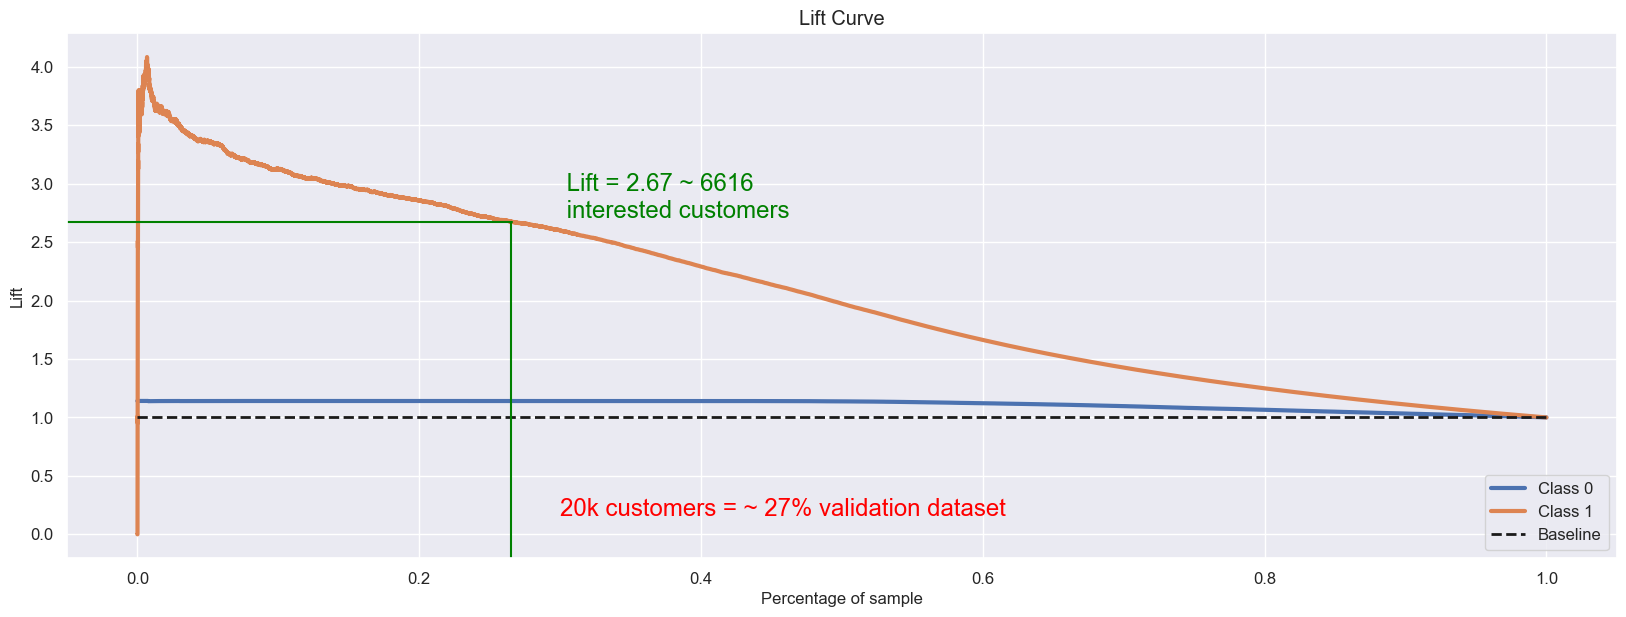

In [54]:
# create a figure object
fig = plt.figure( figsize = (20, 15) )

# create a grid for plotting
specs = gridspec.GridSpec( ncols = 1, nrows = 2, figure = fig) 

# create axs
ax1 = fig.add_subplot( specs[ 0, 0 ] )

# plot accumulative gain
skplt.metrics.plot_lift_curve(y_val, yhat_proba_lgbm, title='Lift Curve', ax = ax1 );

# add 20000 customers contacted line
ax1.axvline( 0.265044,   ymax = 0.64,  color = 'green', label = '20k' )
ax1.axhline( 2.674211, xmax = 0.287, color = 'green' )

plt.text( 0.30 , 0.15 + 0.01, '20k customers = ~ 27% validation dataset', color = 'red', fontsize = 'x-large');
plt.text( 0.30 , 2.7 + 0.01, ' Lift = 2.67 ~ 6616\n interested customers', color = 'green', fontsize = 'x-large');

## Test dataset - Generalização do modelo

In [101]:
x_test = pd.read_csv('./pickle/version_3/x_test.csv')
x_test.head()

,Unnamed: 0,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,200222,200223,Female,21,1,3.00,1,below_1_year,0,20408.00,160.00,72
1,49766,49767,Male,55,1,15.00,0,between_1_2_year,1,37498.00,26.00,102
2,172201,172202,Female,41,1,3.00,0,between_1_2_year,1,2630.00,26.00,90
3,160713,160714,Female,26,1,11.00,0,below_1_year,0,2630.00,151.00,268
4,53272,53273,Male,51,1,40.00,0,between_1_2_year,1,34006.00,124.00,265


In [102]:
x_test = x_test.drop('Unnamed: 0', axis = 1)

In [103]:
x_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,200223,Female,21,1,3.00,1,below_1_year,0,20408.00,160.00,72
1,49767,Male,55,1,15.00,0,between_1_2_year,1,37498.00,26.00,102
2,172202,Female,41,1,3.00,0,between_1_2_year,1,2630.00,26.00,90
3,160714,Female,26,1,11.00,0,below_1_year,0,2630.00,151.00,268
4,53273,Male,51,1,40.00,0,between_1_2_year,1,34006.00,124.00,265


In [104]:
y_test = pd.read_csv('./pickle/version_3/y_test.csv')

In [105]:
y_test = y_test.drop('Unnamed: 0', axis = 1)

In [106]:
y_test.head()

,response
0,0
1,0
2,0
3,0
4,0


### Data preparation

In [107]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_annual_premium.pkl', 'rb' ) )
x_test['annual_premium'] = aux1.fit_transform(x_test[['annual_premium']].values)

In [108]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_age.pkl', 'rb' ) )
x_test['age'] = aux1.fit_transform(x_test[['age']].values)

In [110]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_vintage.pkl', 'rb' ) )
x_test['vintage'] = aux1.fit_transform(x_test[['vintage']].values)

In [111]:
x_test['vintage'].head()

0   0.21
1   0.32
2   0.28
3   0.89
4   0.88
Name: vintage, dtype: float64

In [112]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_gender.pkl', 'rb' ) )

In [113]:
x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( aux1 )

/tmp/ipykernel_9881/2287271548.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_test.loc[:, 'gender'] =  x_test.loc[:, 'gender'].map( aux1 )


In [114]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_region_code.pkl', 'rb' ) )

In [115]:
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map( aux1 )

In [116]:
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] )

In [117]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_fe_policy_sales_channel.pkl', 'rb' ) )
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( aux1 )

In [118]:
x_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
0,200223,0.10,0.02,1,0.13,1,0,-0.58,0.06,0.21,1,0,0
1,49767,0.14,0.54,1,0.08,0,1,0.41,0.21,0.32,0,1,0
2,172202,0.10,0.32,1,0.13,0,1,-1.61,0.21,0.28,0,1,0
3,160714,0.10,0.09,1,0.10,0,0,-1.61,0.01,0.89,1,0,0
4,53273,0.14,0.48,1,0.14,0,1,0.20,0.19,0.88,0,1,0


### predict

Para constatação do desempenho do poder de generalização devemos verificar a performance do modelo no mesmo percentual (26.50%)  do dataset de validação cujo o valor correspondeia a 20 mil clientes.
* 26.50% do dataset de treino corresponde a 10100 clientes 


              Model  Precision_at_k  Recall_at_k
0  LGBM Classifier            0.34         0.71 



,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.34,0.71


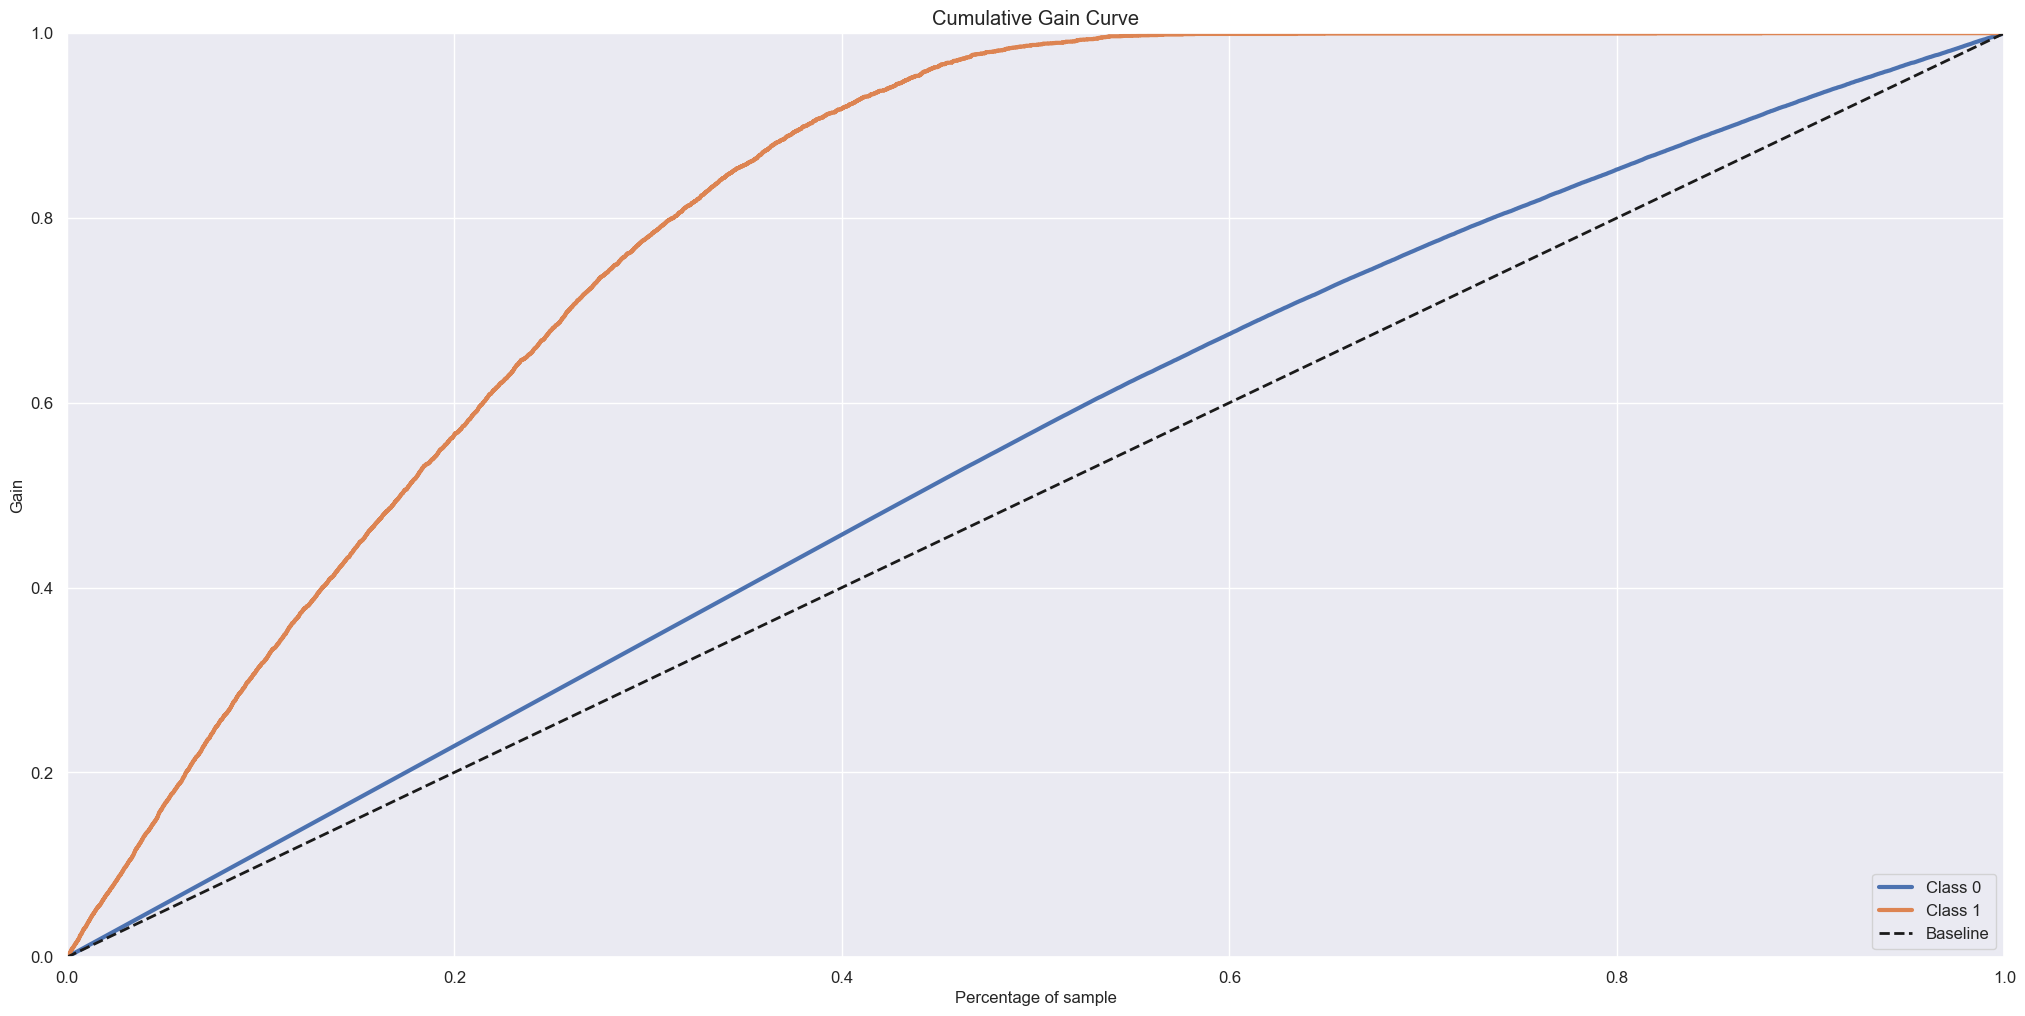

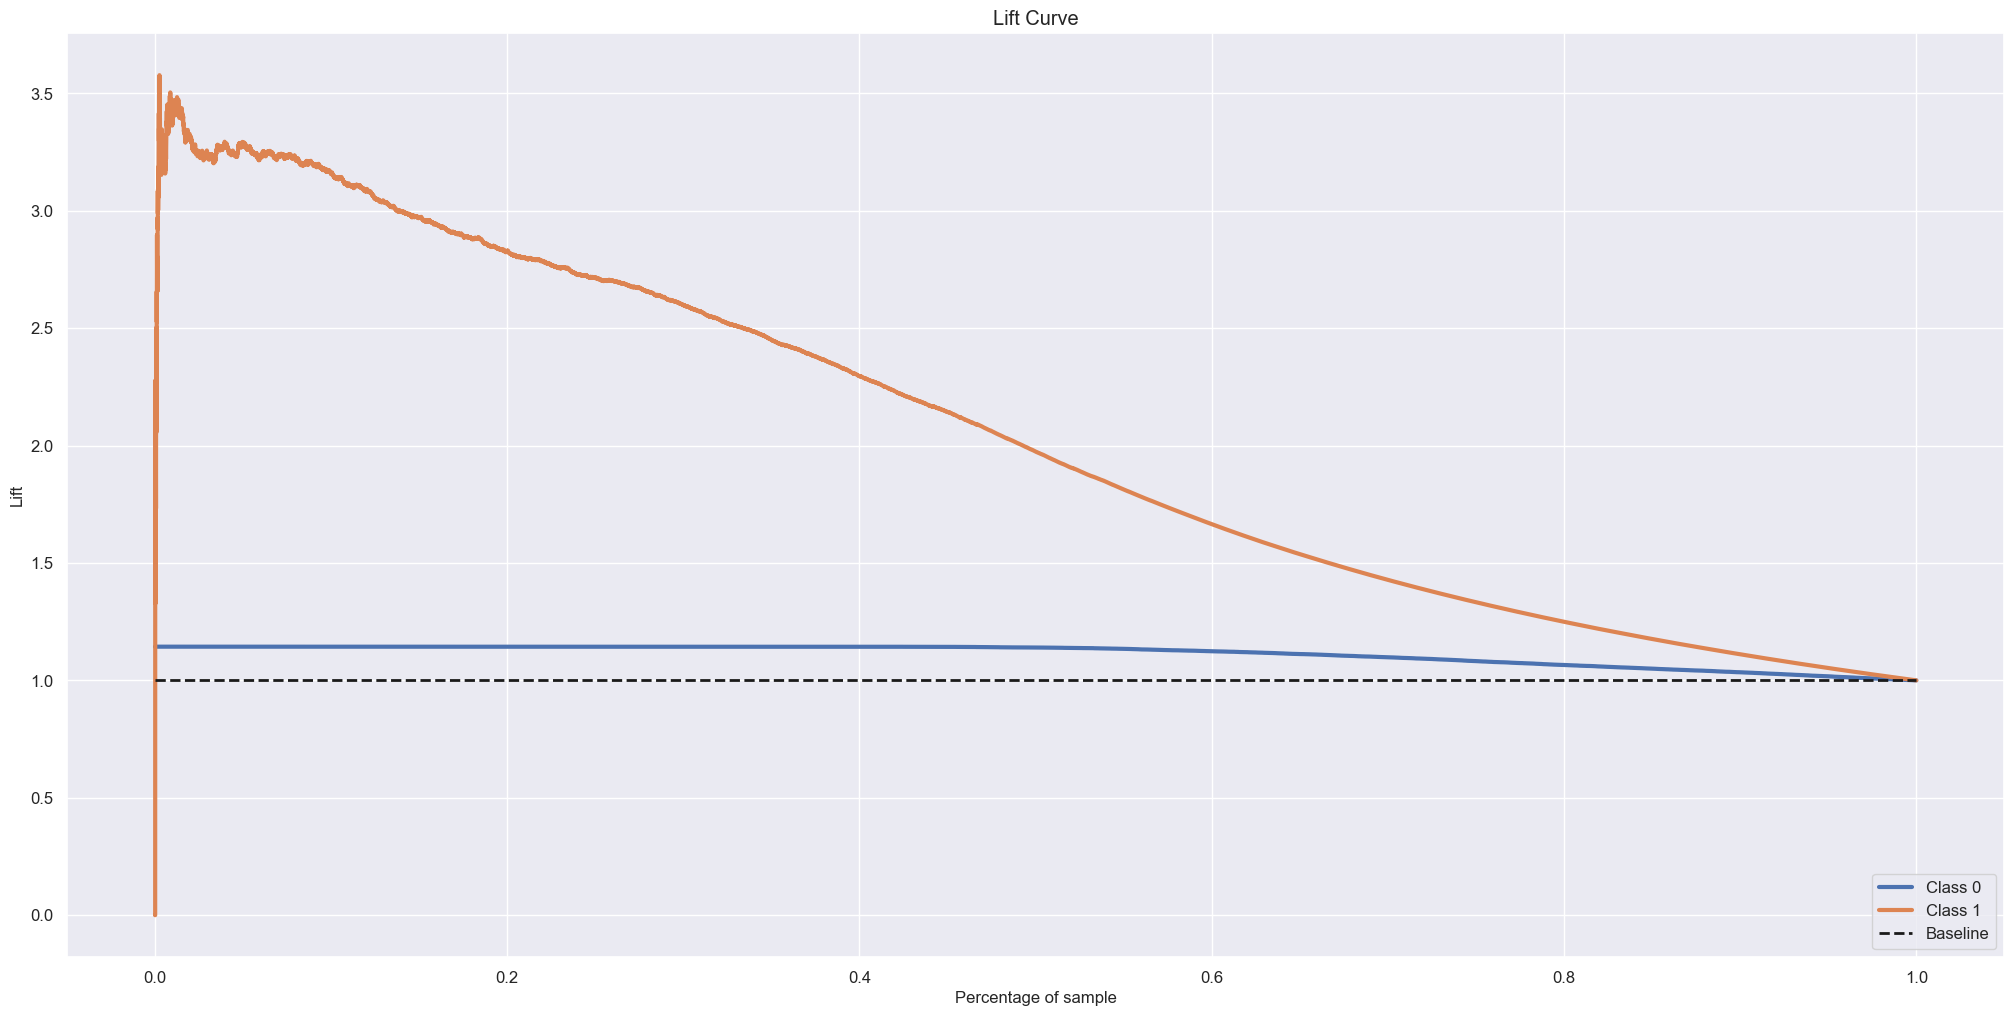

In [122]:
# copy dataframe
df10 = x_test.copy()

cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_test = x_test[ cols_selected ]

#df10 = x_test.copy()
df10['response'] = y_test.copy()

yhat_proba_lgbm = model_lgbm.predict_proba(x_test)
df10['score_0'] = yhat_proba_lgbm[:, 0].tolist()
df10['score_1'] = yhat_proba_lgbm[:, 1].tolist()

result = model_results(model_lgbm, "LGBM Classifier", x_test, y_test, 10100 )
result

In [123]:
# Proporção de 26.50 % do dataset de teste --> valor k = 10101 clientes
df10.shape[0]*0.2650445937528989

10101.11451251673


              Model  Precision_at_k  Recall_at_k
0  LGBM Classifier            0.34         0.71 



,Model,Precision_at_k,Recall_at_k
0,LGBM Classifier,0.34,0.71


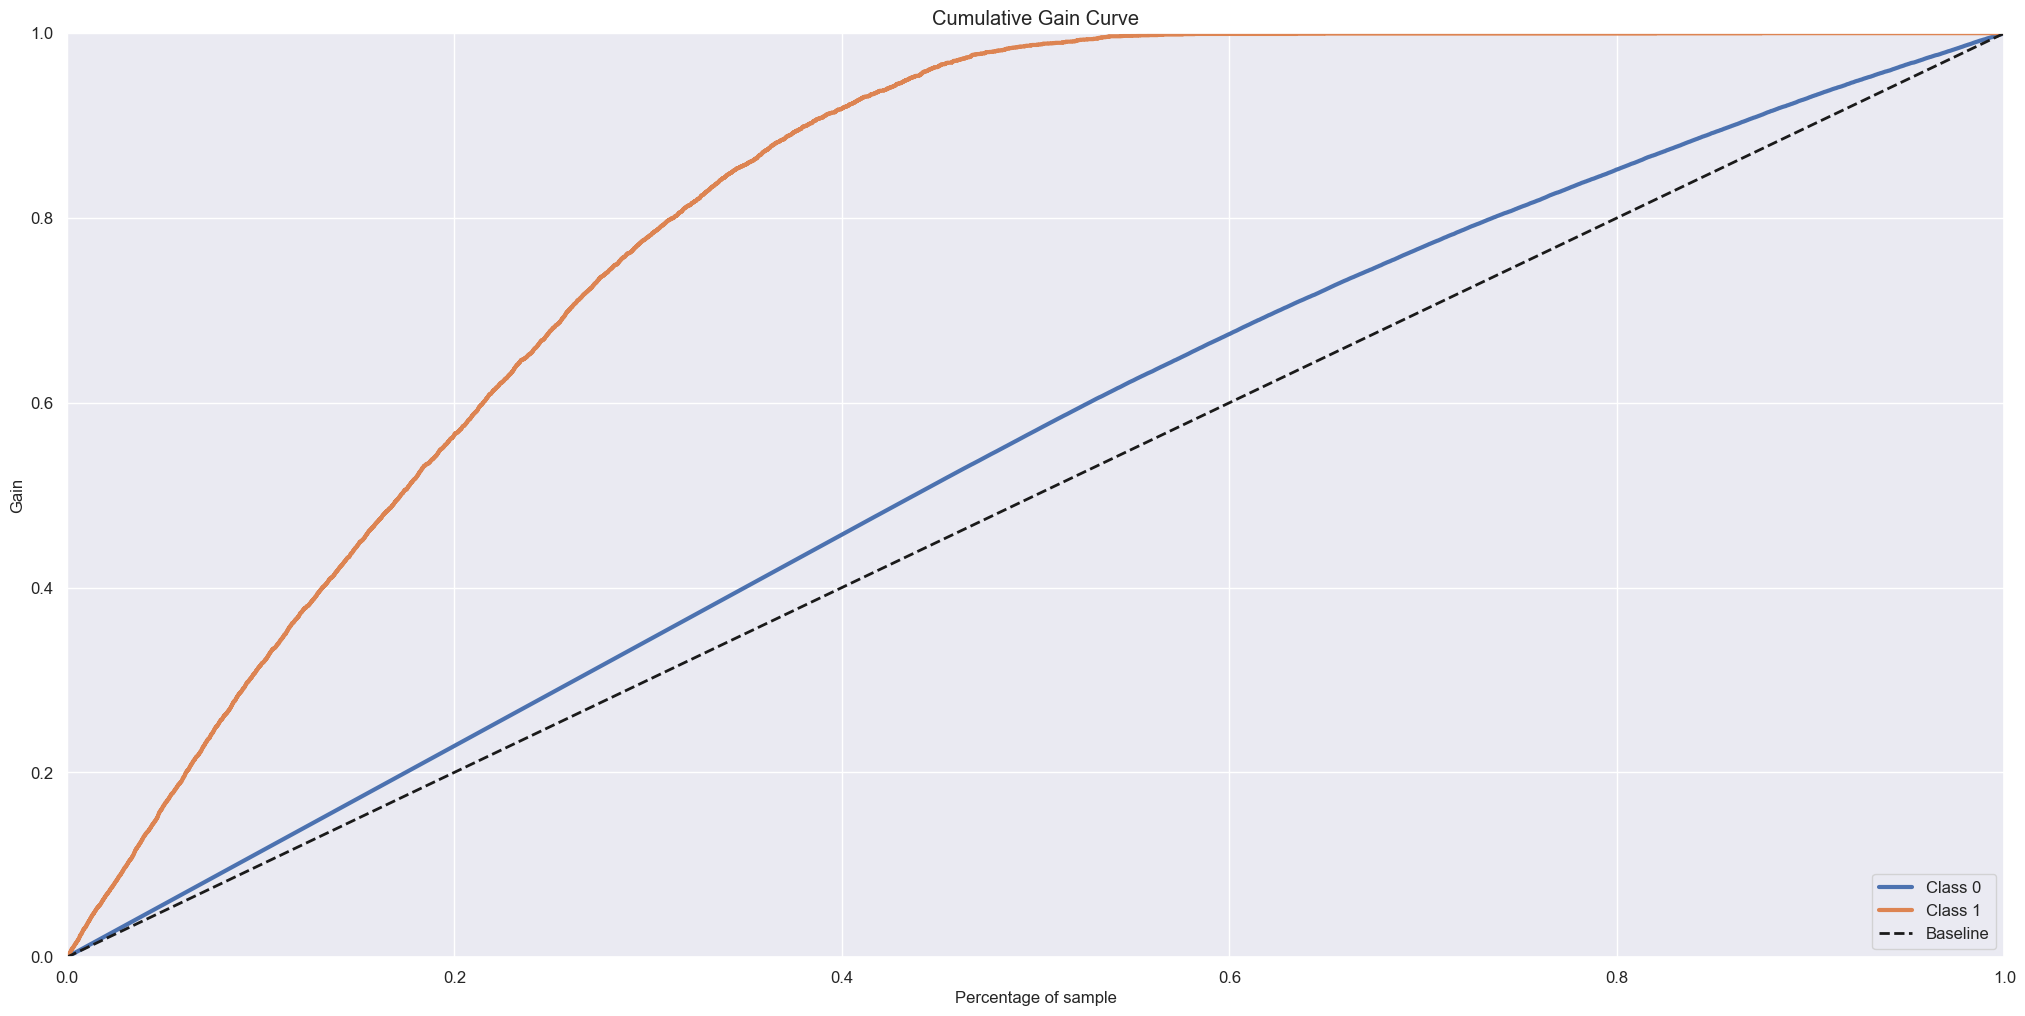

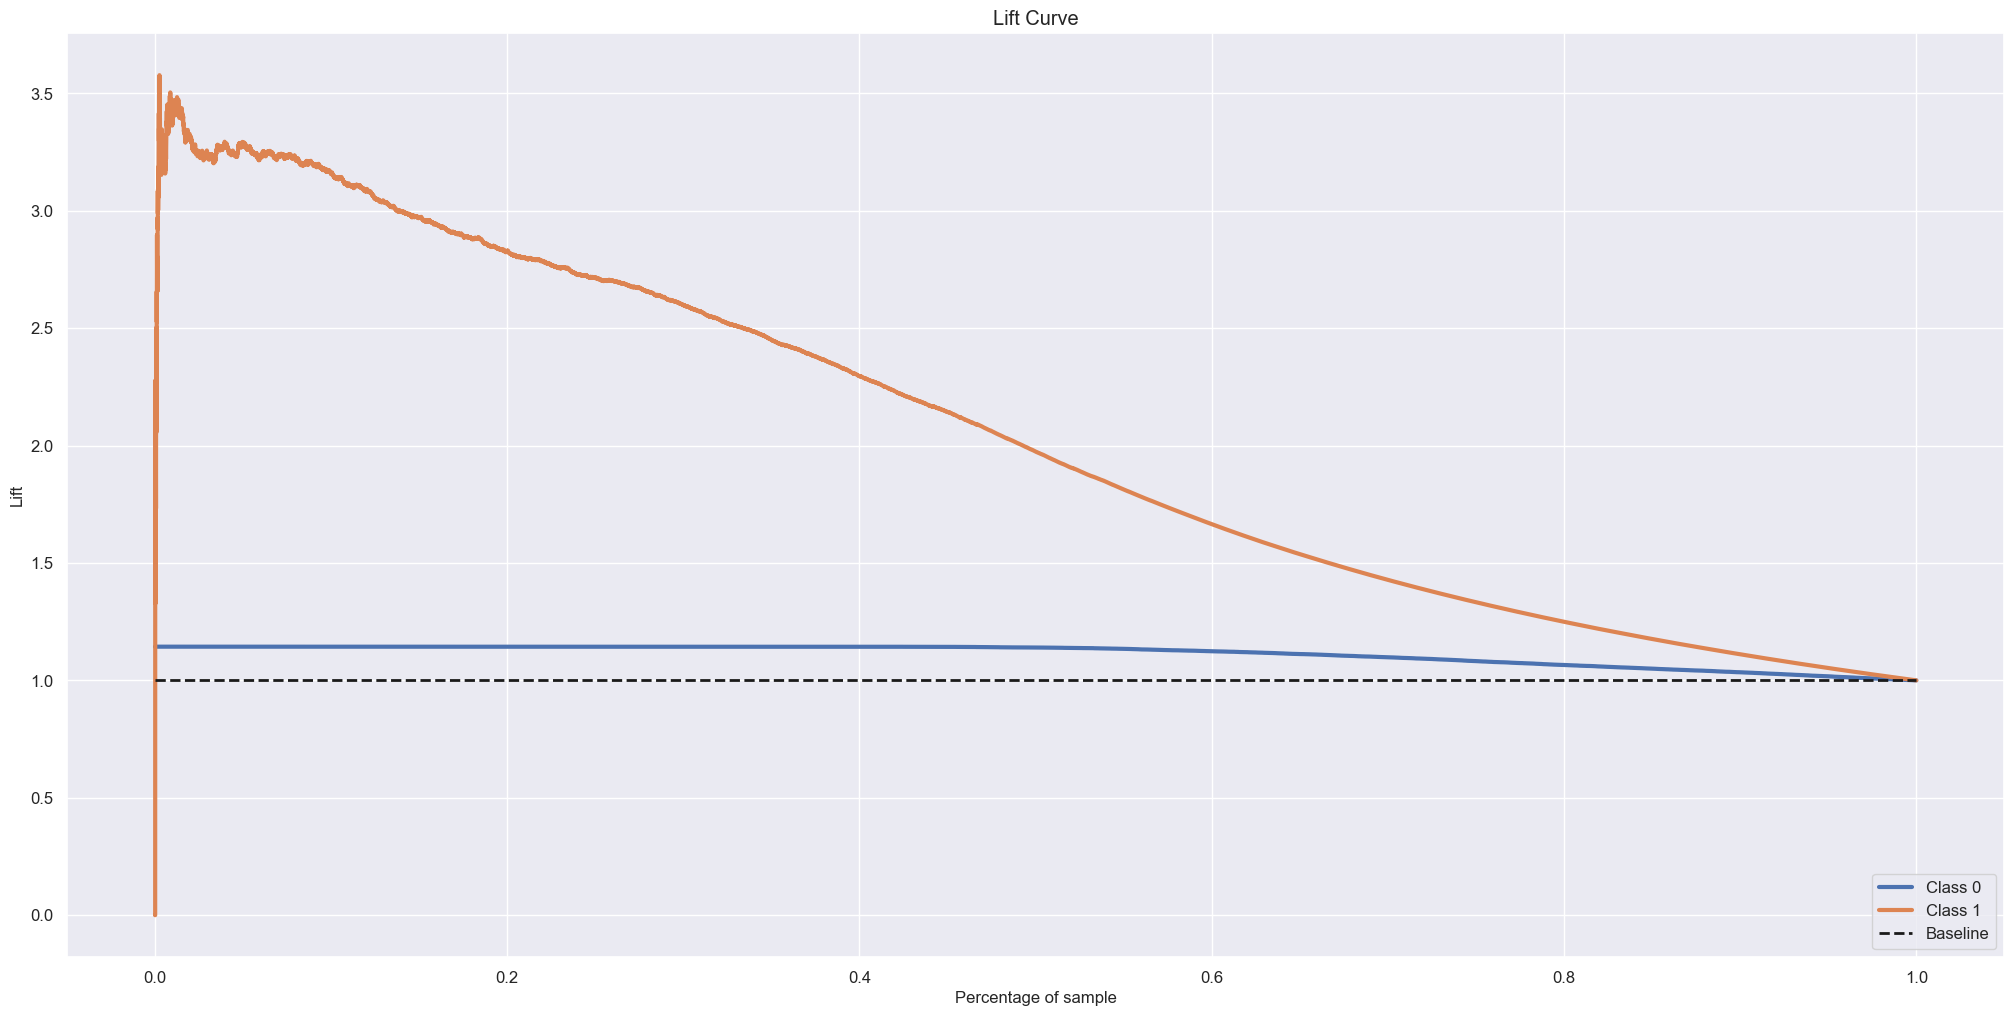

In [124]:
result = model_results(model_lgbm, "LGBM Classifier", x_test, y_test, 10101)
result

In [125]:
# propensity score 1D
df10['score'] = yhat_proba_lgbm[:, 1].tolist()


# sort clients by propensity score
df10 = df10.sort_values( 'score', ascending=False ).reset_index(drop=True)

# Rank
df10['ranking'] = df10.index+1

In [126]:
df10.head(20)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,score_0,score_1,score,ranking
0,268414,0.14,0.00,1,0.12,1,1,-1.61,0.06,0.89,1,0,0,0,0.00,1.00,1.00,1
1,321414,0.10,0.03,1,0.13,1,0,-0.28,0.35,0.98,1,0,0,0,0.12,0.88,0.88,2
2,78285,0.14,0.05,1,0.12,1,0,-0.28,0.35,0.64,1,0,0,0,0.14,0.86,0.86,3
3,32486,0.14,0.02,1,0.12,1,0,-0.28,0.35,0.65,1,0,0,0,0.16,0.84,0.84,4
4,133449,0.14,0.20,1,0.06,0,1,0.53,0.03,1.00,0,1,0,0,0.44,0.56,0.56,5
5,51771,0.14,0.20,1,0.13,0,1,-0.61,0.21,0.82,0,1,0,1,0.48,0.52,0.52,6
6,294226,0.10,0.20,1,0.12,0,1,-0.33,0.02,0.92,0,1,0,1,0.49,0.51,0.51,7
7,145240,0.10,0.15,1,0.13,0,1,-0.55,0.21,0.59,1,0,0,0,0.49,0.51,0.51,8
8,364152,0.10,0.20,1,0.12,0,1,-0.48,0.21,0.09,1,0,0,0,0.49,0.51,0.51,9
9,68247,0.10,0.25,1,0.12,0,1,-0.38,0.21,1.00,0,1,0,0,0.49,0.51,0.51,10


### Análise Conjunto de teste

In [127]:
# 20 mil clientes interessados correspondem a 52.47 % do conjunto de teste
20000 / df10.shape[0]

0.5247828710870878

In [128]:
# total de clientes conjunto de validação
df10.shape[0]

38111

In [129]:
# total de clientes interessados no conjunto de validação
df10['response'].sum()

4783

In [130]:
# percentual de clientes interessados no conjunto de validação
percentual = ( (df10['response'].sum()) / df10.shape[0] ) * 100
percentual

12.550182362047702

In [131]:
# proporção de clientes interessados até posição 20 mil do conjunto de validação
10100*(percentual/100)

1267.5684185668179

### Lista rankeada pelo modelo 

In [132]:
# Total de clientes interessados até a posição 10100 da lista ordenada pelo modelo
df10['response'].loc[df10['ranking']<10100].sum()

3411

In [133]:
# percentual de clientes interessados do total de clientes interessados ordenados pelo modelo até posição 10100
(df10['response'].loc[df10['ranking']<10100].sum()) / df10['response'].sum()

0.7131507422120008

In [135]:
# Total de clientes interessados até a posição 20 mil da lista ordenada pelo modelo
df10['response'].loc[df10['ranking']<20000].sum()

4749

In [136]:
# percentual de clientes interessados do total de clientes interessados ordenados pelo modelo até posição 20 mil
(df10['response'].loc[df10['ranking']<20000].sum()) / df10['response'].sum()

0.9928914906962157

### Dataset de teste Kaggle - Lista de novos clientes

In [137]:
x_test = pd.read_csv('./dataset/test.csv')
x_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.00,1,< 1 Year,No,35786.00,152.00,53
1,381111,Male,40,1,28.00,0,1-2 Year,Yes,33762.00,7.00,111
2,381112,Male,47,1,28.00,0,1-2 Year,Yes,40050.00,124.00,199
3,381113,Male,24,1,27.00,1,< 1 Year,Yes,37356.00,152.00,187
4,381114,Male,27,1,28.00,1,< 1 Year,No,59097.00,152.00,297


### Data preparation

In [138]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_annual_premium.pkl', 'rb' ) )
x_test['Annual_Premium'] = aux1.fit_transform(x_test[['Annual_Premium']].values)

In [139]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_age.pkl', 'rb' ) )
x_test['Age'] = aux1.fit_transform(x_test[['Age']].values)

In [140]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_vintage.pkl', 'rb' ) )
x_test['Vintage'] = aux1.fit_transform(x_test[['Vintage']].values)

In [141]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_gender.pkl', 'rb' ) )
aux1

gender
Female   0.10
Male     0.14
Name: response, dtype: float64

In [142]:
x_test.loc[:, 'Gender'] =  x_test.loc[:, 'Gender'].map( aux1 )

/tmp/ipykernel_9881/3734276522.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_test.loc[:, 'Gender'] =  x_test.loc[:, 'Gender'].map( aux1 )


In [143]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_target_encode_region_code.pkl', 'rb' ) )

In [144]:
x_test.loc[:, 'Region_Code'] = x_test.loc[:, 'Region_Code'].map( aux1 )

In [145]:
x_test = pd.get_dummies( x_test, prefix='Vehicle_Age', columns=['Vehicle_Age'] )

In [146]:
aux1 = pickle.load( open( '/home/deivison/Documentos/projetos/pa_04/pickle/version_3/x_test_fe_policy_sales_channel.pkl', 'rb' ) )
x_test.loc[:, 'Policy_Sales_Channel'] = x_test['Policy_Sales_Channel'].map( aux1 )

In [147]:
x_test['Vehicle_Damage'] = x_test['Vehicle_Damage'].apply(lambda x: 1 if x =='Yes' else 0)

In [148]:
x_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,381110,0.14,0.08,1,0.10,1,0,0.31,0.35,0.15,0,1,0
1,381111,0.14,0.31,1,0.19,0,1,0.19,0.00,0.35,1,0,0
2,381112,0.14,0.42,1,0.19,0,1,0.56,0.19,0.65,1,0,0
3,381113,0.14,0.06,1,0.07,1,1,0.40,0.35,0.61,0,1,0
4,381114,0.14,0.11,1,0.19,1,0,1.69,0.35,0.99,0,1,0


### Predict

In [149]:
# copy dataframe
df10 = x_test.copy()

cols_selected = ['Annual_Premium', 'Vintage', 'Age', 'Region_Code', 'Vehicle_Damage', 'Previously_Insured',
                 'Policy_Sales_Channel']

x_test = x_test[ cols_selected ]

#df10 = x_test.copy()
#df10['response'] = y_test.copy()

yhat_proba_lgbm = model_lgbm.predict_proba(x_test)
df10['score_0'] = yhat_proba_lgbm[:, 0].tolist()
df10['score_1'] = yhat_proba_lgbm[:, 1].tolist()

In [150]:
df10.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,score_0,score_1
0,381110,0.14,0.08,1,0.10,1,0,0.31,0.35,0.15,0,1,0,1.00,0.00
1,381111,0.14,0.31,1,0.19,0,1,0.19,0.00,0.35,1,0,0,0.69,0.31
2,381112,0.14,0.42,1,0.19,0,1,0.56,0.19,0.65,1,0,0,0.70,0.30
3,381113,0.14,0.06,1,0.07,1,1,0.40,0.35,0.61,0,1,0,1.00,0.00
4,381114,0.14,0.11,1,0.19,1,0,1.69,0.35,0.99,0,1,0,1.00,0.00


### Lista rankeada pelo modelo 

In [151]:
df11 = df10[['id','score_1']].copy()
df11.shape

(127037, 2)

In [152]:
df11 = df11.sort_values('score_1', ascending = False)
df11.head(20)

,id,score_1
111767,492877,1.00
126743,507853,1.00
11307,392417,0.92
31198,412308,0.88
123539,504649,0.88
110421,491531,0.87
32050,413160,0.87
56899,438009,0.86
89006,470116,0.67
11174,392284,0.56


In [153]:
#df11.to_csv('./dataset/lista_ordenada.csv')